In [6]:
import pandas as pd 
import numpy as np 
from pybaseball import statcast_pitcher, pitching_stats, pitching_stats_bref, playerid_lookup
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from scipy.spatial.distance import pdist, squareform
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.cluster import KMeans
import os

In [2]:
pd.set_option('display.max_columns', None)


*Insert Plan and Descritpion of Approach Here and the Defnitition of Deception*

1. Look at Swing and Miss Rate Leaders
    - References: Baseball Savant/ Statcast

2. Results
     - According to Baseball Savant/Statcast
        1. Skubal, Tarik
        2. Wheeler, Zack
        3. Sale, Chris
        4. Lopez, Reynaldo
        5. Skenes, Paul

3. Find and Get Their Pitching Stats using Pybaseball's Libraries 



In [7]:
# List of player names
player_name_list = [ 'Lugo Seth', 'Skenes Paul']

# Set the date range for the 2024 season
start_date = '2024-03-28'  # Approximate opening day
end_date = '2024-10-06'    # Approximate end of regular season

# Create a folder for CSV files if it doesn't exist
csv_folder = 'CSV_Files'
os.makedirs(csv_folder, exist_ok=True)

# Loop through the player names, retrieve data, and save as CSV
for player in player_name_list:
    # Split the name into last name and first name
    last_name, first_name = player.split()
    
    try:
        # Lookup the player ID
        player_id = playerid_lookup(last_name, first_name)['key_mlbam'].iloc[0]
        
        print(f"Retrieving data for {player} (ID: {player_id})...")
        
        # Get all available data for the pitcher for the 2024 Season
        data = statcast_pitcher(start_dt=start_date, end_dt=end_date, player_id=player_id)
        
        if not data.empty:
            # Create a filename for the CSV
            filename = f"{last_name}_{first_name}_2024.csv"
            filepath = os.path.join(csv_folder, filename)
            
            # Save the data as a CSV file
            data.to_csv(filepath, index=False)
            print(f"Data saved to {filepath}")
        else:
            print(f"No data available for {player}")
    
    except IndexError:
        print(f"Player ID not found for {player}")
    except Exception as e:
        print(f"An error occurred while processing {player}: {str(e)}")

print("Data retrieval and CSV creation complete.")

Retrieving data for Lugo Seth (ID: 607625)...
Gathering Player Data
Data saved to CSV_Files\Lugo_Seth_2024.csv
Retrieving data for Skenes Paul (ID: 694973)...
Gathering Player Data
Data saved to CSV_Files\Skenes_Paul_2024.csv
Data retrieval and CSV creation complete.


In [8]:

import re

# Specify the folder containing the CSV files
csv_folder = 'CSV_Files'

# Get a list of all CSV files in the folder
csv_files = [f for f in os.listdir(csv_folder) if f.endswith('.csv')]

# Create a list to store the variable names
dataframe_vars = []

# Loop through each CSV file and create a DataFrame
for i, file in enumerate(csv_files, 1):
    # Get the player name from the filename (assuming format: LastName_FirstName_2024.csv)
    player_name = '_'.join(file.split('_')[:2])
    
    # Create a valid variable name
    var_name = f"data_{i}_{re.sub('[^0-9a-zA-Z]+', '_', player_name)}"
    
    # Read the CSV file into a DataFrame
    file_path = os.path.join(csv_folder, file)
    df = pd.read_csv(file_path)
    
    # Create a new variable with the DataFrame
    globals()[var_name] = df
    
    # Add the variable name to our list
    dataframe_vars.append(var_name)
    
    # Print a message to confirm the DataFrame was created
    print(f"DataFrame '{var_name}' created for {player_name}")

# Print out the names of all created DataFrame variables
print("\nCreated DataFrame variables:")
for var in dataframe_vars:
    print(var)


DataFrame 'data_1_Lugo_Seth' created for Lugo_Seth
DataFrame 'data_2_Sale_Chris' created for Sale_Chris
DataFrame 'data_3_Skenes_Paul' created for Skenes_Paul
DataFrame 'data_4_Skubal_Tarik' created for Skubal_Tarik
DataFrame 'data_5_Wheeler_Zack' created for Wheeler_Zack

Created DataFrame variables:
data_1_Lugo_Seth
data_2_Sale_Chris
data_3_Skenes_Paul
data_4_Skubal_Tarik
data_5_Wheeler_Zack


In [ ]:

def analyze_pitching_deception(data, league_average_smr=0.11):
    data = data.dropna(subset=['effective_speed', 'release_spin_rate', 'release_speed', 'player_name', 'p_throws'])

    # Dropping columns with NAN values
    data = data.dropna(axis=1)
    data = data.reset_index(drop=True)

    # Get the pitcher's name and throwing hand
    pitcher_name = data['player_name'].iloc[0]
    pitcher_hand = data['p_throws'].iloc[0]

    # Adjust release_pos_x for left-handed pitchers
    if pitcher_hand == 'L':
        data['release_pos_x'] = data['release_pos_x'] * -1

    # Calculate total pitches, swings, and misses for each pitch type
    pitch_counts = data.groupby('pitch_type').size()
    total_swings = data[data['description'].isin(['swinging_strike', 'foul', 'foul_tip', 'foul_bunt', 'bunt_foul_tip', 'missed_bunt', 'hit_into_play'])].groupby('pitch_type').size()
    total_misses = data[data['description'] == 'swinging_strike'].groupby('pitch_type').size()

    # Create a DataFrame for swing-and-miss rates by pitch type
    swing_and_miss_rate = pd.DataFrame({
        'pitch_type': pitch_counts.index,
        'total_pitches': pitch_counts.values,
        'total_swings': total_swings.reindex(pitch_counts.index, fill_value=0).values,
        'total_misses': total_misses.reindex(pitch_counts.index, fill_value=0).values
    })

    # Calculate swing-and-miss rate, handling division by zero
    swing_and_miss_rate['swing_and_miss_rate'] = np.where(
        swing_and_miss_rate['total_swings'] > 0,
        swing_and_miss_rate['total_misses'] / swing_and_miss_rate['total_swings'],
        0
    )

    # Calculate pitch usage
    swing_and_miss_rate['pitch_usage'] = swing_and_miss_rate['total_pitches'] / swing_and_miss_rate['total_pitches'].sum()

    # Normalize swing-and-miss rate against league average
    swing_and_miss_rate['normalized_smr'] = swing_and_miss_rate['swing_and_miss_rate'] / league_average_smr * 100

    # Calculate weighted normalized SMR
    swing_and_miss_rate['weighted_normalized_smr'] = swing_and_miss_rate['normalized_smr'] * swing_and_miss_rate['pitch_usage']

    # Calculate overall SMR score
    smr_score = swing_and_miss_rate['weighted_normalized_smr'].sum()

    # Merge swing-and-miss rates back to original data
    pitch_summary = data.groupby('pitch_type').agg({
        'release_pos_x': 'mean',
        'release_pos_y': 'mean',
        'release_pos_z': 'mean',
        'effective_speed': 'mean',
        'release_speed': 'mean'
    }).reset_index()

    # Merge swing-and-miss rates with pitch summary
    pitch_summary = pitch_summary.merge(swing_and_miss_rate, on='pitch_type', how='left')

    # Sort pitch_summary by swing_and_miss_rate
    pitch_summary = pitch_summary.sort_values('swing_and_miss_rate')

    # Print summary statistics
    print(f"Pitching Summary for {pitcher_name}:")
    print(pitch_summary)

    # Create a color map from red to green based on swing-and-miss rates
    colors = plt.cm.RdYlGn(np.linspace(0, 1, len(pitch_summary)))

    # Create spray charts
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8), gridspec_kw={'width_ratios': [3, 1]})
    
    # Scatter plot of release position colored by pitch type
    scatter = ax1.scatter(pitch_summary['release_pos_x'],
                          pitch_summary['release_pos_z'],
                          s=pitch_summary['effective_speed'] * 2,  # Adjust size scaling
                          c=colors,
                          alpha=0.7)

    # Add pitch type labels and location annotations to the scatter plot
    for idx, row in pitch_summary.iterrows():
        ax1.annotate(f"{row['pitch_type']}\n({row['release_pos_x']:.2f}, {row['release_pos_z']:.2f})",
                     (row['release_pos_x'], row['release_pos_z']),
                     xytext=(10, 5),
                     textcoords='offset points',
                     fontsize=8,
                     alpha=0.8,
                     bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))

    ax1.set_title(f'Spray Chart of Release Position for {pitcher_name}')
    ax1.set_xlabel('Release Position X')
    ax1.set_ylabel('Release Position Z')
    
    # Add a legend for pitch types
    legend_elements = [plt.Line2D([0], [0], marker='o', color='w',
                                  label=pitch, markerfacecolor=color, markersize=10)
                       for pitch, color in zip(pitch_summary['pitch_type'], colors)]
    ax1.legend(handles=legend_elements, title='Pitch Types', loc='best')

    # Add grid to the scatter plot
    ax1.grid(True, linestyle='--', alpha=0.7)

    # Add swing-and-miss rates next to the scatter plot
    ax2.barh(pitch_summary['pitch_type'], pitch_summary['swing_and_miss_rate'], color=colors)
    ax2.set_title(f'Swing-and-Miss Rates for {pitcher_name}')
    ax2.set_xlabel('Rate')
    ax2.set_xlim(0, 1)  # Set x-axis limit from 0 to 1 for percentage

    # Add percentage labels to the end of each bar
    for i, v in enumerate(pitch_summary['swing_and_miss_rate']):
        ax2.text(v, i, f' {v:.1%}', va='center')

    # Add grid to the bar plot
    ax2.grid(True, linestyle='--', alpha=0.7)
        
    # Calculate mean release positions for FF and CH
    ff_row = pitch_summary[pitch_summary['pitch_type'] == 'FF']
    ch_row = pitch_summary[pitch_summary['pitch_type'] == 'CH']

    if not ff_row.empty and not ch_row.empty:
        ff_position = (ff_row['release_pos_x'].values[0], ff_row['release_pos_z'].values[0])
        ch_position = (ch_row['release_pos_x'].values[0], ch_row['release_pos_z'].values[0])

        # Plot a red line between FF and CH
        ax1.plot([ff_position[0], ch_position[0]], 
                    [ff_position[1], ch_position[1]], 
                    color='red', 
                    linewidth=2)

        # Calculate and annotate distance
        distance = np.sqrt((ff_position[0] - ch_position[0]) ** 2 + (ff_position[1] - ch_position[1]) ** 2)
        mid_point_x = (ff_position[0] + ch_position[0]) / 2
        mid_point_y = (ff_position[1] + ch_position[1]) / 2

        ax1.annotate(f'Distance: {distance:.2f} ft',
                        xy=(mid_point_x, mid_point_y),
                        xytext=(mid_point_x + 5, mid_point_y + 5),
                        fontsize=10,
                        color='red',
                        arrowprops=dict(facecolor='red', shrink=0.05))
        
    plt.tight_layout()

    # Print SMR score
    print(f"\nSwing and Miss Rate (SMR) Score for {pitcher_name}: {smr_score:.2f}")

    # Print detailed swing-and-miss statistics
    print("\nDetailed Swing-and-Miss Statistics:")
    print(swing_and_miss_rate)

    return fig, smr_score

# Main execution
if __name__ == "__main__":
    # Set the folder path
    folder_path = "CSV_Files"
    
    # Create a dictionary to store SMR scores for each pitcher
    smr_scores = {}

    # Iterate through all CSV files in the folder
    for filename in os.listdir(folder_path):
        if filename.endswith(".csv"):
            # Extract pitcher name from the filename (assuming filename format is "PitcherName.csv")
            pitcher_name = os.path.splitext(filename)[0]
            
            # Full path to the CSV file
            file_path = os.path.join(folder_path, filename)
            
            # Read the CSV file
            data = pd.read_csv(file_path)
            
            print(f"\nAnalyzing data for {pitcher_name}...")
            
            # Run the analysis
            fig, smr_score = analyze_pitching_deception(data, league_average_smr=0.11)
            
            # Store the SMR score
            smr_scores[pitcher_name] = smr_score
            
            # Save the plot
            fig.savefig(f"{pitcher_name}_analysis.png")
            plt.close(fig)  # Close the plot to free up memory

    # Print overall results
    print("\nOverall SMR Scores:")
    for pitcher, score in smr_scores.items():
        print(f"{pitcher}: {score:.2f}")

    # Create a bar plot of SMR scores
    plt.figure(figsize=(12, 6))
    plt.bar(smr_scores.keys(), smr_scores.values())
    plt.title("SMR Scores Comparison")
    plt.xlabel("Pitcher")
    plt.ylabel("SMR Score")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig("SMR_Scores_Comparison.png")
    plt.close()

    print("\nAnalysis complete. Individual plots and overall comparison have been saved.")


Analyzing data for Lugo_Seth_2024...
Pitching Summary for Lugo, Seth:
  pitch_type  release_pos_x  release_pos_y  release_pos_z  effective_speed  \
7         ST      -1.497619      54.603730       5.322937        81.103968   
5         SI      -1.246294      54.296041       5.348714        92.066836   
3         FF      -1.228709      54.382738       5.514524        92.122816   
6         SL      -1.299067      54.512267       5.517000        86.585667   
2         FC      -1.379737      54.464737       5.632707        89.943609   
8         SV      -1.425963      54.694317       5.481615        77.659317   
0         CH      -1.313244      54.450222       5.472667        87.176000   
1         CU      -1.359961      54.723041       5.560195        78.653021   
4         FS      -1.252048      54.391205       5.528554        85.768675   

   release_speed  total_pitches  total_swings  total_misses  \
7      81.734127            126            48             5   
5      92.179019      

C:\Users\ramon\AppData\Local\Temp\ipykernel_19824\2574741459.py:273: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()



Swing and Miss Rate (SMR) Score for Lugo, Seth: 174.95

Detailed Swing-and-Miss Statistics:
  pitch_type  total_pitches  total_swings  total_misses  swing_and_miss_rate  \
0         CH            225           106            29             0.273585   
1         CU            513           243            71             0.292181   
2         FC            266           130            24             0.184615   
3         FF            767           319            46             0.144201   
4         FS             83            38            13             0.342105   
5         SI            591           283            32             0.113074   
6         SL            300           143            25             0.174825   
7         ST            126            48             5             0.104167   
8         SV            322           160            41             0.256250   

   pitch_usage  normalized_smr  weighted_normalized_smr  
0     0.070467      248.713551                17

C:\Users\ramon\AppData\Local\Temp\ipykernel_19824\2574741459.py:273: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()



Analyzing data for Skenes_Paul_2024...
Pitching Summary for Skenes, Paul:
  pitch_type  release_pos_x  release_pos_y  release_pos_z  effective_speed  \
2         FF      -2.258429      54.064341       5.695000        98.995683   
5         ST      -2.238372      54.131349       5.595488        84.786512   
3         SI      -2.323648      54.124793       5.646186        94.202322   
1         CU      -2.491435      54.138130       5.727826        83.226957   
4         SL      -2.225426      54.084031       5.568217        86.692248   
0         CH      -2.630877      54.151667       5.650263        87.278947   

   release_speed  total_pitches  total_swings  total_misses  \
2      98.824101            834           422            85   
5      84.710698            215            93            19   
3      93.987231            603           337            95   
1      82.980000            230            82            25   
4      86.530233            129            58            18   


C:\Users\ramon\AppData\Local\Temp\ipykernel_19824\2574741459.py:273: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()



Analyzing data for Skubal_Tarik_2024...
Pitching Summary for Skubal, Tarik:
  pitch_type  release_pos_x  release_pos_y  release_pos_z  effective_speed  \
3         SI      -1.690470      54.120201       6.143372        96.762248   
2         KC      -1.589752      54.164711       6.244793        78.644628   
1         FF      -1.584869      54.129224       6.225635        96.965582   
4         SL      -1.930888      54.134766       6.117897        89.236916   
0         CH      -1.729421      54.208327       6.146013        86.293962   

   release_speed  total_pitches  total_swings  total_misses  \
3      96.676174            596           283            34   
2      78.486777            121            40             7   
1      96.871563            953           501           116   
4      88.816355            428           191            60   
0      86.380377            795           466           191   

   swing_and_miss_rate  pitch_usage  normalized_smr  weighted_normalized_sm

C:\Users\ramon\AppData\Local\Temp\ipykernel_19824\2574741459.py:273: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()



Analyzing data for Wheeler_Zack_2024...
Pitching Summary for Wheeler, Zack:
  pitch_type  release_pos_x  release_pos_y  release_pos_z  effective_speed  \
4         SI      -2.083027      53.278776       5.175894        96.213043   
1         FC      -2.183803      53.405049       5.199607        92.843934   
2         FF      -2.099049      53.254042       5.256360        96.988707   
0         CU      -2.170810      53.614548       5.308754        82.793146   
5         ST      -2.217573      53.538083       5.157524        86.036408   
3         FS      -2.124167      53.193958       5.243875        87.853750   

   release_speed  total_pitches  total_swings  total_misses  \
4      94.702254            621           328            42   
1      91.174754            305           154            24   
2      95.336256           1346           704           194   
0      81.817134            321           131            38   
5      85.072087            412           200            67  

In [ ]:



from scipy import stats
def bootstrap_flyout_percentage(data, num_bootstrap_samples=1000):
    bootstrap_means = []
    for _ in range(num_bootstrap_samples):
        sample = data.sample(n=len(data), replace=True)
        bootstrap_means.append(sample.mean())
    return np.percentile(bootstrap_means, [2.5, 97.5])

def calculate_wcr(data, launch_angle_thresholds=(10, 25), exit_velocity_threshold=80):
    """
    Calculate the Weak Contact Rate (WCR).
    
    Parameters:
    - data: DataFrame containing pitch data with 'launch_angle', 'launch_speed'.
    - launch_angle_thresholds: Tuple defining the range of angles considered weak contact.
    - exit_velocity_threshold: Exit velocity threshold for weak contact.
    
    Returns:
    - WCR score
    """
    # Define weak contact conditions
    weak_contact_condition = (
        (data['launch_angle'] >= launch_angle_thresholds[0]) &
        (data['launch_angle'] <= launch_angle_thresholds[1]) &
        (data['launch_speed'] < exit_velocity_threshold)
    )
    
    # Calculate weak contact rate
    total_batted_balls = data.shape[0]
    weak_contact_count = weak_contact_condition.sum()
    
    wcr = (weak_contact_count / total_batted_balls) * 100 if total_batted_balls > 0 else 0
    
    return wcr

def launch_angle_plots():
    # Specify the folder containing CSV files
    csv_folder = 'CSV_Files'
    
    # Create a folder for saving plots if it doesn't exist
    plots_folder = 'Launch_Angle_Flyout_Plots'
    os.makedirs(plots_folder, exist_ok=True)
    
    # Get a list of all CSV files in the specified folder
    csv_files = [f for f in os.listdir(csv_folder) if f.endswith('.csv')]
    
    for csv_file in csv_files:
        # Extract player name from the filename
        player_name = ' '.join(csv_file.split('_')[:2])  # Assumes format "LastName_FirstName_Year.csv"

        # Read the CSV file
        file_path = os.path.join(csv_folder, csv_file)
        data = pd.read_csv(file_path)
        
        # Filter out NaN values
        pitcher_data = data.dropna(subset=['events', 'description', 'launch_angle', 'launch_speed'])
        
        # Define flyout conditions
        flyout_condition = (
            ((pitcher_data['events'] == 'field_out') & (pitcher_data['description'].isin(['hit_into_play', 'foul']))) |
            (pitcher_data['events'] == 'sac_fly')
        )
        
        # Add is_flyout column
        pitcher_data['is_flyout'] = flyout_condition
        
        # Create a scatter plot of launch angle vs. exit velocity
        plt.figure(figsize=(12, 8))
        sns.scatterplot(data=pitcher_data, x='launch_speed', y='launch_angle', hue='is_flyout', palette={True: 'red', False: 'blue'})
        
        # Add reference lines for fly out ranges
        plt.axhline(y=25, color='g', linestyle='--', label='Fly ball lower limit')
        plt.axhline(y=50, color='g', linestyle='--', label='Fly ball upper limit')
        
        plt.title(f'Launch Angle vs. Exit Velocity for {player_name}')
        plt.xlabel('Exit Velocity (mph)')
        plt.ylabel('Launch Angle (degrees)')
        plt.legend(title='Flyout', labels=['Other', 'Flyout'], bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        
        # Save the plot
        plt.savefig(os.path.join(plots_folder, f'{player_name}_Launch_Angle_vs_Exit_Velocity.png'))
        plt.close()
        
        # Calculate percentage of fly outs and ground outs
        total_batted_balls = pitcher_data.shape[0]
        fly_outs = pitcher_data['is_flyout'].sum()
        
        fly_out_percentage = (fly_outs / total_batted_balls) * 100 if total_batted_balls > 0 else 0
        
        print(f"Analyzing {player_name}:")
        print(f"Fly out percentage: {fly_out_percentage:.2f}%")
        
        # Calculate Weak Contact Rate (WCR)
        wcr_score = calculate_wcr(pitcher_data)
        
        print(f"Weak Contact Rate (WCR) Score for {player_name}: {wcr_score:.2f}%")
        
        # Analyze pitch types
        pitch_type_analysis = pitcher_data.groupby('pitch_type').agg({
            'launch_angle': 'mean',
            'launch_speed': 'mean',
            'is_flyout': lambda x: x.sum() / len(x) * 100
        }).reset_index()

        # Calculate confidence intervals
        ci_low, ci_high = zip(*pitcher_data.groupby('pitch_type')['is_flyout'].apply(bootstrap_flyout_percentage))
        pitch_type_analysis['CI_low'] = ci_low
        pitch_type_analysis['CI_high'] = ci_high

        pitch_type_analysis.columns = ['Pitch Type', 'Avg Launch Angle', 'Avg Exit Velocity', 'Fly Out %', 'CI_low', 'CI_high']
        
        print("\nPitch Type Analysis:")
        print(pitch_type_analysis)

        # Calculate error bar values
        lower_error = pitch_type_analysis['Fly Out %'] - pitch_type_analysis['CI_low']
        upper_error = pitch_type_analysis['CI_high'] - pitch_type_analysis['Fly Out %']

        # Ensure no negative values
        lower_error = np.maximum(lower_error, 0)
        upper_error = np.maximum(upper_error, 0)

        # Visualize pitch type effectiveness with error bars
        plt.figure(figsize=(12, 6))
        ax = sns.barplot(data=pitch_type_analysis, x='Pitch Type', y='Fly Out %')

        # Add error bars manually
        ax.errorbar(x=range(len(pitch_type_analysis)), 
                    y=pitch_type_analysis['Fly Out %'],
                    yerr=[lower_error, upper_error],
                    fmt='none', color='black', capsize=5)

        plt.title(f'Fly Out Percentage by Pitch Type for {player_name}')
        plt.ylabel('Fly Out Percentage')
        plt.xticks(rotation=45)

        # Add value labels on top of each bar
        for i, v in enumerate(pitch_type_analysis['Fly Out %']):
            ax.text(i, v, f'{v:.1f}%', ha='center', va='bottom')

        plt.tight_layout()
        
        # Save the plot
        plt.savefig(os.path.join(plots_folder, f'{player_name}_Fly_Out_Percentage_by_Pitch_Type.png'))
        plt.close()

        # Print out confidence intervals
        print("\nFly Out Percentages with 95% Confidence Intervals:")
        for _, row in pitch_type_analysis.iterrows():
            print(f"{row['Pitch Type']}: {row['Fly Out %']:.2f}% (95% CI: {row['CI_low']:.2f}% - {row['CI_high']:.2f}%)")

# Call the function to analyze all CSV files in the 'CSV_Files' folder
try:
     launch_angle_plots()
except Exception as e:
     print(f"An error occurred during the analysis: {str(e)}")
     with open('error_log.txt', 'a') as f:
         f.write(f"Error occurred at {pd.Timestamp.now()}: {str(e)}\n")

C:\Users\ramon\AppData\Local\Temp\ipykernel_15768\289801278.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pitcher_data['is_flyout'] = flyout_condition


Analyzing Lugo Seth:
Fly out percentage: 61.97%
Weak Contact Rate (WCR) Score for Lugo Seth: 2.79%

Pitch Type Analysis:
  Pitch Type  Avg Launch Angle  Avg Exit Velocity  Fly Out %    CI_low  \
0         CH          1.324324          83.654054  67.567568  0.540541   
1         CU          4.563380          90.100000  64.788732  0.535211   
2         FC         16.687500          86.306250  60.416667  0.458333   
3         FF         17.154412          89.186029  62.500000  0.544118   
4         FS          5.666667          88.766667  66.666667  0.416667   
5         SI          2.272109          86.330612  55.102041  0.476020   
6         SL         14.738462          91.736923  69.230769  0.569231   
7         ST         26.523810          92.700000  52.380952  0.332143   
8         SV         12.657534          84.494521  65.753425  0.547945   

    CI_high  
0  0.810811  
1  0.760563  
2  0.729167  
3  0.705882  
4  0.916667  
5  0.632653  
6  0.800000  
7  0.714286  
8  0.767123 

C:\Users\ramon\AppData\Local\Temp\ipykernel_15768\289801278.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pitcher_data['is_flyout'] = flyout_condition


Analyzing Sale Chris:
Fly out percentage: 62.06%
Weak Contact Rate (WCR) Score for Sale Chris: 4.45%

Pitch Type Analysis:
  Pitch Type  Avg Launch Angle  Avg Exit Velocity  Fly Out %    CI_low  \
0         CH          4.978022          83.009890  72.527473  0.637363   
1         FF         12.800000          91.768148  51.851852  0.429630   
2         SI         -6.477273          88.100000  63.636364  0.500000   
3         SL         12.929936          82.407006  64.331210  0.566879   

    CI_high  
0  0.813187  
1  0.607407  
2  0.772727  
3  0.713376  

Fly Out Percentages with 95% Confidence Intervals:
CH: 72.53% (95% CI: 0.64% - 0.81%)
FF: 51.85% (95% CI: 0.43% - 0.61%)
SI: 63.64% (95% CI: 0.50% - 0.77%)
SL: 64.33% (95% CI: 0.57% - 0.71%)


C:\Users\ramon\AppData\Local\Temp\ipykernel_15768\289801278.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pitcher_data['is_flyout'] = flyout_condition


Analyzing Skenes Paul:
Fly out percentage: 59.02%
Weak Contact Rate (WCR) Score for Skenes Paul: 3.93%

Pitch Type Analysis:
  Pitch Type  Avg Launch Angle  Avg Exit Velocity  Fly Out %    CI_low  \
0         CH         10.071429          76.392857  71.428571  0.500000   
1         CU         17.000000          84.170370  55.555556  0.370370   
2         FF         13.522124          91.003540  54.867257  0.451327   
3         SI         -5.137615          87.516514  60.550459  0.513532   
4         SL         18.250000          79.631250  56.250000  0.312500   
5         ST         23.692308          86.953846  69.230769  0.500000   

    CI_high  
0  0.928571  
1  0.740741  
2  0.637389  
3  0.688303  
4  0.812500  
5  0.846154  

Fly Out Percentages with 95% Confidence Intervals:
CH: 71.43% (95% CI: 0.50% - 0.93%)
CU: 55.56% (95% CI: 0.37% - 0.74%)
FF: 54.87% (95% CI: 0.45% - 0.64%)
SI: 60.55% (95% CI: 0.51% - 0.69%)
SL: 56.25% (95% CI: 0.31% - 0.81%)
ST: 69.23% (95% CI: 0.50% - 0.8

C:\Users\ramon\AppData\Local\Temp\ipykernel_15768\289801278.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pitcher_data['is_flyout'] = flyout_condition


Analyzing Skubal Tarik:
Fly out percentage: 63.56%
Weak Contact Rate (WCR) Score for Skubal Tarik: 3.85%

Pitch Type Analysis:
  Pitch Type  Avg Launch Angle  Avg Exit Velocity  Fly Out %    CI_low  \
0         CH         10.590909          86.172727  57.142857  0.493506   
1         FF         18.478873          87.221127  64.084507  0.563380   
2         KC         13.111111          88.038889  83.333333  0.666667   
3         SI          5.377953          86.538583  68.503937  0.598425   
4         SL         12.905660          88.475472  62.264151  0.490566   

    CI_high  
0  0.649351  
1  0.718310  
2  1.000000  
3  0.755906  
4  0.754717  

Fly Out Percentages with 95% Confidence Intervals:
CH: 57.14% (95% CI: 0.49% - 0.65%)
FF: 64.08% (95% CI: 0.56% - 0.72%)
KC: 83.33% (95% CI: 0.67% - 1.00%)
SI: 68.50% (95% CI: 0.60% - 0.76%)
SL: 62.26% (95% CI: 0.49% - 0.75%)


C:\Users\ramon\AppData\Local\Temp\ipykernel_15768\289801278.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pitcher_data['is_flyout'] = flyout_condition


Analyzing Wheeler Zack:
Fly out percentage: 65.18%
Weak Contact Rate (WCR) Score for Wheeler Zack: 5.25%

Pitch Type Analysis:
  Pitch Type  Avg Launch Angle  Avg Exit Velocity  Fly Out %    CI_low  \
0         CU         12.658537          90.919512  53.658537  0.390244   
1         FC         23.230769          82.938462  71.153846  0.596154   
2         FF         22.273743          89.355307  65.363128  0.581006   
3         FS          2.900000          82.550000  66.666667  0.500000   
4         SI          0.354167          84.002083  63.194444  0.548611   
5         ST         16.632353          81.873529  70.588235  0.602941   

    CI_high  
0  0.683537  
1  0.826923  
2  0.720670  
3  0.833333  
4  0.715278  
5  0.808824  

Fly Out Percentages with 95% Confidence Intervals:
CU: 53.66% (95% CI: 0.39% - 0.68%)
FC: 71.15% (95% CI: 0.60% - 0.83%)
FF: 65.36% (95% CI: 0.58% - 0.72%)
FS: 66.67% (95% CI: 0.50% - 0.83%)
SI: 63.19% (95% CI: 0.55% - 0.72%)
ST: 70.59% (95% CI: 0.60% - 0

In [25]:
def create_movement_plot(data):
    """
    Creates a movement plot showing horizontal and vertical break for each pitch type,
    with average spin rate annotated for each pitch type.

    Parameters:
    - data: DataFrame containing pitch data with columns 'player_name', 'pitch_type', 'pfx_x',
            'pfx_z', and 'release_spin_rate'.

    Returns:
    - matplotlib figure
    """
    # Ensure data is a DataFrame
    if not isinstance(data, pd.DataFrame):
        raise TypeError("Input must be a pandas DataFrame")

    # Drop rows with missing values in relevant columns
    plot_data = data.dropna(subset=['player_name', 'pitch_type', 'pfx_x', 'pfx_z', 'release_spin_rate'])

    # Get the pitcher's name
    pitcher_name = plot_data['player_name'].iloc[0]

    # Calculate average spin rate for each pitch type
    avg_spin_rates = plot_data.groupby('pitch_type')['release_spin_rate'].mean().round().astype(int)

    # Create the plot
    plt.figure(figsize=(12, 8))
    
    # Create a scatter plot
    sns.scatterplot(data=plot_data, x='pfx_x', y='pfx_z',
                    hue='pitch_type', palette='deep')

    # Customize the plot
    plt.title(f'Pitch Movement Plot for {pitcher_name}', fontsize=16)
    plt.xlabel('Horizontal Movement (inches)', fontsize=12)
    plt.ylabel('Vertical Movement (inches)', fontsize=12)
    plt.axhline(y=0, color='k', linestyle='--', linewidth=0.5)
    plt.axvline(x=0, color='k', linestyle='--', linewidth=0.5)

    # Add average spin rate annotations
    for pitch_type in avg_spin_rates.index:
        pitch_data = plot_data[plot_data['pitch_type'] == pitch_type]
        avg_x = pitch_data['pfx_x'].mean()
        avg_y = pitch_data['pfx_z'].mean()
        plt.annotate(f"{pitch_type}\n{avg_spin_rates[pitch_type]} rpm",
                     (avg_x, avg_y),
                     textcoords="offset points",
                     xytext=(0,10),
                     ha='center',
                     fontsize=8,
                     bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))

    # Adjust layout
    plt.tight_layout()

    return plt

PMD SCORE

In [ ]:

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def load_data(file_path):
    return pd.read_csv(file_path)

def calculate_expected_movement(velocity, spin_rate, pitch_type):
    # Constants (these are placeholder values, you'd need to adjust these)
    k_horizontal = 0.00006
    k_vertical = 0.00004
    
    # Basic calculation
    expected_horizontal = k_horizontal * spin_rate / velocity
    expected_vertical = k_vertical * spin_rate / velocity
    
    # Adjust based on pitch type (very simplified)
    if pitch_type in ['FF', 'FT']:  # Four-seam or two-seam fastball
        expected_vertical *= 1.2
    elif pitch_type in ['SL', 'CU']:  # Slider or curveball
        expected_horizontal *= 1.5
        expected_vertical *= -1
    elif pitch_type == 'CH':  # Changeup
        expected_vertical *= 0.8
    
    return expected_horizontal, expected_vertical

def calculate_pmd_score(data, league_average_deviation=2.0):
    # Calculate total deviation for each pitch
    data['total_deviation'] = np.sqrt(data['x_deviation']**2 + data['z_deviation']**2)
    
    # Calculate average deviation for each pitch type
    pitch_deviations = data.groupby('pitch_type')['total_deviation'].mean()
    
    # Calculate pitch usage
    pitch_usage = data['pitch_type'].value_counts(normalize=True)
    
    # Normalize deviations against league average (larger deviations result in higher scores)
    normalized_deviations = pitch_deviations / league_average_deviation
    
    # Weight by pitch usage and calculate overall score
    pmd_score = (normalized_deviations * pitch_usage).sum() * 100
    
    return pmd_score, pitch_deviations

def analyze_pitch_deception(data):
    # Calculate expected movement
    data['expected_pfx_x'], data['expected_pfx_z'] = zip(*data.apply(
        lambda row: calculate_expected_movement(row['release_speed'], row['release_spin_rate'], row['pitch_type']),
        axis=1
    ))
    
    # Calculate deviation from expected movement
    data['x_deviation'] = data['pfx_x'] - data['expected_pfx_x']
    data['z_deviation'] = data['pfx_z'] - data['expected_pfx_z']
    
    # Calculate PMD score
    pmd_score, pitch_deviations = calculate_pmd_score(data)
    
    return data, pmd_score, pitch_deviations

def plot_movement_comparison(data, pitcher_name):
    pitch_types = data['pitch_type'].unique()
    n_pitches = len(pitch_types)
    
    # Calculate grid dimensions
    n_cols = 3  # You can adjust this
    n_rows = (n_pitches - 1) // n_cols + 1
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(6*n_cols, 5*n_rows), squeeze=False)
    fig.suptitle(f'Actual vs Expected Movement - {pitcher_name}', fontsize=16)
    
    for idx, pitch_type in enumerate(pitch_types):
        row = idx // n_cols
        col = idx % n_cols
        ax = axes[row, col]
        
        pitch_data = data[data['pitch_type'] == pitch_type]
        
        # Actual movement
        ax.scatter(pitch_data['pfx_x'], pitch_data['pfx_z'], 
                   s=50, alpha=0.7, color='blue', label='Actual')
        
        # Expected movement
        ax.scatter(pitch_data['expected_pfx_x'], pitch_data['expected_pfx_z'], 
                   color='red', marker='x', s=50, alpha=0.7, label='Expected')
        
        # Draw lines between actual and expected
        for _, pitch in pitch_data.iterrows():
            ax.plot([pitch['pfx_x'], pitch['expected_pfx_x']], 
                    [pitch['pfx_z'], pitch['expected_pfx_z']], 
                    color='gray', linestyle='--', linewidth=0.5, alpha=0.3)
        
        ax.set_title(f'{pitch_type}')
        ax.set_xlabel('Horizontal Movement (inches)')
        ax.set_ylabel('Vertical Movement (inches)')
        
        # Add a legend for each subplot
        ax.legend()
    
    # Remove any unused subplots
    for idx in range(n_pitches, n_rows * n_cols):
        row = idx // n_cols
        col = idx % n_cols
        fig.delaxes(axes[row, col])
    
    plt.tight_layout()
    
    # Save the plot with the pitcher's name
    plt.savefig(os.path.join('Actual_VS_Expected_Movement', f'{pitcher_name}_Actual_vs_Expected_Movement.png'))
    plt.close()

def main():
    # Specify the folder containing CSV files
    csv_folder = 'CSV_Files'
    
    # Create a folder for saving plots if it doesn't exist
    plots_folder = 'Actual_VS_Expected_Movement'
    os.makedirs(plots_folder, exist_ok=True)
    
    # Get a list of all CSV files in the specified folder
    csv_files = [f for f in os.listdir(csv_folder) if f.endswith('.csv')]
    
    pmd_scores = {}
    
    for csv_file in csv_files:
        # Extract player name from the filename
        pitcher_name = ' '.join(csv_file.split('_')[:2])  # Assumes format "LastName_FirstName_Year.csv"

        # Load data from the CSV file
        file_path = os.path.join(csv_folder, csv_file)
        data = load_data(file_path)
        
        # Analyze pitch deception
        data, pmd_score, pitch_deviations = analyze_pitch_deception(data)
        
        # Store PMD score
        pmd_scores[pitcher_name] = pmd_score
        
        # Print PMD score and pitch-specific deviations
        print(f"\nPitch Movement Deviation (PMD) Score for {pitcher_name}: {pmd_score:.2f}")
        print("Average deviations by pitch type:")
        for pitch_type, deviation in pitch_deviations.items():
            print(f"{pitch_type}: {deviation:.2f} inches")
        
        # Plot results and save the figure with the pitcher's name
        plot_movement_comparison(data, pitcher_name)

    # Create a bar plot of PMD scores
    plt.figure(figsize=(12, 6))
    plt.bar(pmd_scores.keys(), pmd_scores.values())
    plt.title("PMD Scores Comparison")
    plt.xlabel("Pitcher")
    plt.ylabel("PMD Score")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig("PMD_Scores_Comparison.png")
    plt.close()

if __name__ == "__main__":
    main()



Pitch Movement Deviation (PMD) Score for Lugo Seth: 67.82
Average deviations by pitch type:
CH: 1.34 inches
CU: 1.72 inches
FC: 0.99 inches
FF: 1.42 inches
FS: 0.99 inches
SI: 1.47 inches
SL: 0.56 inches
ST: 1.23 inches
SV: 1.62 inches

Pitch Movement Deviation (PMD) Score for Sale Chris: 64.32
Average deviations by pitch type:
CH: 1.36 inches
FF: 1.51 inches
SI: 1.50 inches
SL: 1.01 inches

Pitch Movement Deviation (PMD) Score for Skenes Paul: 61.64
Average deviations by pitch type:
CH: 1.49 inches
CU: 0.69 inches
FF: 1.50 inches
SI: 1.20 inches
SL: 0.65 inches
ST: 1.08 inches

Pitch Movement Deviation (PMD) Score for Skubal Tarik: 65.24
Average deviations by pitch type:
CH: 1.36 inches
FF: 1.47 inches
KC: 0.83 inches
SI: 1.59 inches
SL: 0.57 inches

Pitch Movement Deviation (PMD) Score for Wheeler Zack: 64.19
Average deviations by pitch type:
CU: 1.04 inches
FC: 0.74 inches
FF: 1.47 inches
FS: 1.17 inches
SI: 1.56 inches
ST: 0.92 inches


RELEASE POINT Deviation

In [ ]:

def calculate_rpd_score(data, league_average_std=0.1):
    """
    Calculate the Release Point Deviation (RPD) score.
    
    Parameters:
    - data: DataFrame containing pitch data
    - league_average_std: League average standard deviation for release points
    
    Returns:
    - RPD score
    """
    # Calculate standard deviation of release points for each pitch type
    release_std = data.groupby('pitch_type').agg({
        'release_pos_x': 'std',
        'release_pos_z': 'std'
    }).mean(axis=1)  # Average of x and z standard deviations
    
    # Calculate pitch usage
    pitch_usage = data['pitch_type'].value_counts(normalize=True)
    
    # Normalize release point deviation (lower deviation is better)
    normalized_rpd = league_average_std / release_std
    
    # Weight by pitch usage and calculate overall score
    rpd_score = (normalized_rpd * pitch_usage).sum() * 100
    
    return rpd_score

def create_movement_release_plots(data, pitcher_name, pitch_selection='all'):
    """
    Creates individual plots for each pitch type showing the relationship between
    release position and movement for both horizontal and vertical dimensions.
    Adjusts release_pos_x for left-handed pitchers.

    Parameters:
    - data: DataFrame containing pitch data
    - pitcher_name: Name of the pitcher for saving plots
    - pitch_selection: 'all' for all pitches, or 'FF_CH' for only Four-seam Fastball and Changeup

    Returns:
    - RPD score
    """
    # Ensure data is a DataFrame
    if not isinstance(data, pd.DataFrame):
        raise TypeError("Input must be a pandas DataFrame")

    # Drop rows with missing values in relevant columns
    plot_data = data.dropna(subset=['pitch_type', 'pfx_x', 'pfx_z', 'release_pos_x', 'release_pos_z', 'release_spin_rate', 'p_throws'])

    # Adjust release_pos_x for left-handed pitchers
    plot_data = plot_data.copy()  # Create a copy to avoid SettingWithCopyWarning
    if plot_data['p_throws'].iloc[0] == 'L':
        plot_data['release_pos_x'] = plot_data['release_pos_x'] * -1

    # Select pitch types based on the pitch_selection parameter
    if pitch_selection == 'FF_CH':
        selected_pitches = ['FF', 'CH']
        pitch_types = [pt for pt in selected_pitches if pt in plot_data['pitch_type'].unique()]
        if len(pitch_types) == 0:
            raise ValueError("Neither 'FF' nor 'CH' found in the dataset")
    else:
        pitch_types = plot_data['pitch_type'].unique()

    # Calculate RPD score
    rpd_score = calculate_rpd_score(plot_data)

    # Create a directory to save plots if it doesn't exist
    plots_folder = 'Pitcher_Movement_Plots'
    os.makedirs(plots_folder, exist_ok=True)

    # Create a plot for each pitch type
    for pitch_type in pitch_types:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
        fig.suptitle(f'Movement vs Release Position for {pitch_type} - {pitcher_name}', fontsize=16)
        
        pitch_data = plot_data[plot_data['pitch_type'] == pitch_type]
        
        # Horizontal movement vs release position
        sns.scatterplot(data=pitch_data, x='release_pos_x', y='pfx_x', ax=ax1)
        ax1.set_title('Horizontal Movement', fontsize=14)
        ax1.set_xlabel('Release Position X (ft)', fontsize=12)
        ax1.set_ylabel('Horizontal Movement (inches)', fontsize=12)
        ax1.axhline(y=0, color='k', linestyle='--', linewidth=0.5)
        ax1.axvline(x=0, color='k', linestyle='--', linewidth=0.5)

        # Vertical movement vs release position
        sns.scatterplot(data=pitch_data, x='release_pos_z', y='pfx_z', ax=ax2)
        ax2.set_title('Vertical Movement', fontsize=14)
        ax2.set_xlabel('Release Position Z (ft)', fontsize=12)
        ax2.set_ylabel('Vertical Movement (inches)', fontsize=12)
        ax2.axhline(y=0, color='k', linestyle='--', linewidth=0.5)
        ax2.axvline(x=0, color='k', linestyle='--', linewidth=0.5)

        # Add average spin rate annotation
        avg_spin_rate = pitch_data['release_spin_rate'].mean().round().astype(int)
        fig.text(0.5, 0.02, f'Average Spin Rate: {avg_spin_rate} rpm', ha='center', fontsize=12)

        # Add handedness information
        handedness = "Left-handed" if plot_data['p_throws'].iloc[0] == 'L' else "Right-handed"
        fig.text(0.5, 0.97, f'{handedness} Pitcher', ha='center', fontsize=12)

        plt.tight_layout()
        
        # Save the figure with the pitcher's name and pitch type
        plt.savefig(os.path.join(plots_folder, f'{pitcher_name}_{pitch_type}_Movement_Plot.png'))
        
        plt.close(fig)  # Close the figure to free up memory

    return rpd_score

def main():
    # Specify the folder containing CSV files
    csv_folder = 'CSV_Files'

    # Get a list of all CSV files in the specified folder
    csv_files = [f for f in os.listdir(csv_folder) if f.endswith('.csv')]

    rpd_scores = {}

    for csv_file in csv_files:
        # Extract pitcher name from the filename
        pitcher_name = ' '.join(csv_file.split('_')[:2])  # Assumes format "LastName_FirstName_Year.csv"
        
        # Load data from the CSV file
        file_path = os.path.join(csv_folder, csv_file)
        
        try:
            data = pd.read_csv(file_path)
            rpd_score = create_movement_release_plots(data, pitcher_name=pitcher_name, pitch_selection='FF_CH')
            rpd_scores[pitcher_name] = rpd_score
            print(f"RPD Score for {pitcher_name}: {rpd_score:.2f}")
        except ValueError as e:
            print(f"Error processing {pitcher_name}: {e}")
        except Exception as e:
            print(f"An error occurred while reading {pitcher_name}: {str(e)}")

    # Create a bar plot of RPD scores
    plt.figure(figsize=(12, 6))
    plt.bar(rpd_scores.keys(), rpd_scores.values())
    plt.title("RPD Scores Comparison")
    plt.xlabel("Pitcher")
    plt.ylabel("RPD Score")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig("RPD_Scores_Comparison.png")
    plt.close()

if __name__ == "__main__":
    main()

RPD Score for Lugo Seth: 72.92
RPD Score for Sale Chris: 60.50
RPD Score for Skenes Paul: 48.86
RPD Score for Skubal Tarik: 69.13
RPD Score for Wheeler Zack: 90.26


Interpretation of Error Bars in Pitching Deception
Variability in Release Points:


    -Spacious Error Bars: If the error bars representing standard deviation are large, it indicates a high variability in the release points for that particular pitch type. This variability can suggest that the pitcher has multiple release points or inconsistent mechanics, which can contribute to deception.
    -Deceptive Mechanics: A pitcher who can vary their release point while maintaining similar pitch characteristics (like speed and spin) may confuse batters, making it harder for them to predict where the ball will end up. This unpredictability can enhance the effectiveness of certain pitches.


Pitch Type Specificity:


    - Different pitch types may show different levels of variability. For instance, a fastball might have tighter release point consistency compared to a breaking ball. If a pitcher has a wide range of release points for their breaking pitches, it could indicate that they are intentionally trying to create confusion for batters.
    - Conversely, if a pitch type shows low variability (narrow error bars), it may indicate that the pitcher is more consistent with that pitch, which could make it more predictable.
Strategic Choice vs. Inconsistency:

Intentional Variation:
    - Spacious error bars might imply that the pitcher is deliberately varying their release points as part of their strategy to deceive batters. This can be an effective tactic if executed well.
Unintentional Inconsistency: 

    -Alternatively, large error bars could also indicate inconsistency in the pitcher’s mechanics or technique, which might not be intentional. This could lead to decreased effectiveness if batters learn to exploit these inconsistencies.
Quantifying Deception:

    -The relationship between error bars and deception is not straightforward; while larger error bars can suggest potential deception through variability, they also raise questions about control and repeatability.
    -It’s essential to analyze how these metrics correlate with other performance indicators, such as swing-and-miss rates or batting averages against specific pitches.
Visual Representation:

    -When visualizing these metrics, clear labeling and legends are crucial for interpretation. Including descriptions of what spacious error bars imply regarding pitcher deception will help viewers understand the data better.

COMBINING Both scripts for swing and miss rates and correlation to pitch release points

Processing Lugo_Seth...
Columns in DataFrame: ['pitch_type', 'game_date', 'release_speed', 'release_pos_x', 'release_pos_z', 'player_name', 'batter', 'pitcher', 'events', 'description', 'spin_dir', 'spin_rate_deprecated', 'break_angle_deprecated', 'break_length_deprecated', 'zone', 'des', 'game_type', 'stand', 'p_throws', 'home_team', 'away_team', 'type', 'hit_location', 'bb_type', 'balls', 'strikes', 'game_year', 'pfx_x', 'pfx_z', 'plate_x', 'plate_z', 'on_3b', 'on_2b', 'on_1b', 'outs_when_up', 'inning', 'inning_topbot', 'hc_x', 'hc_y', 'tfs_deprecated', 'tfs_zulu_deprecated', 'fielder_2', 'umpire', 'sv_id', 'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'sz_top', 'sz_bot', 'hit_distance_sc', 'launch_speed', 'launch_angle', 'effective_speed', 'release_spin_rate', 'release_extension', 'game_pk', 'pitcher.1', 'fielder_2.1', 'fielder_3', 'fielder_4', 'fielder_5', 'fielder_6', 'fielder_7', 'fielder_8', 'fielder_9', 'release_pos_y', 'estimated_ba_using_speedangle', 'estimated_woba_using_speedangle

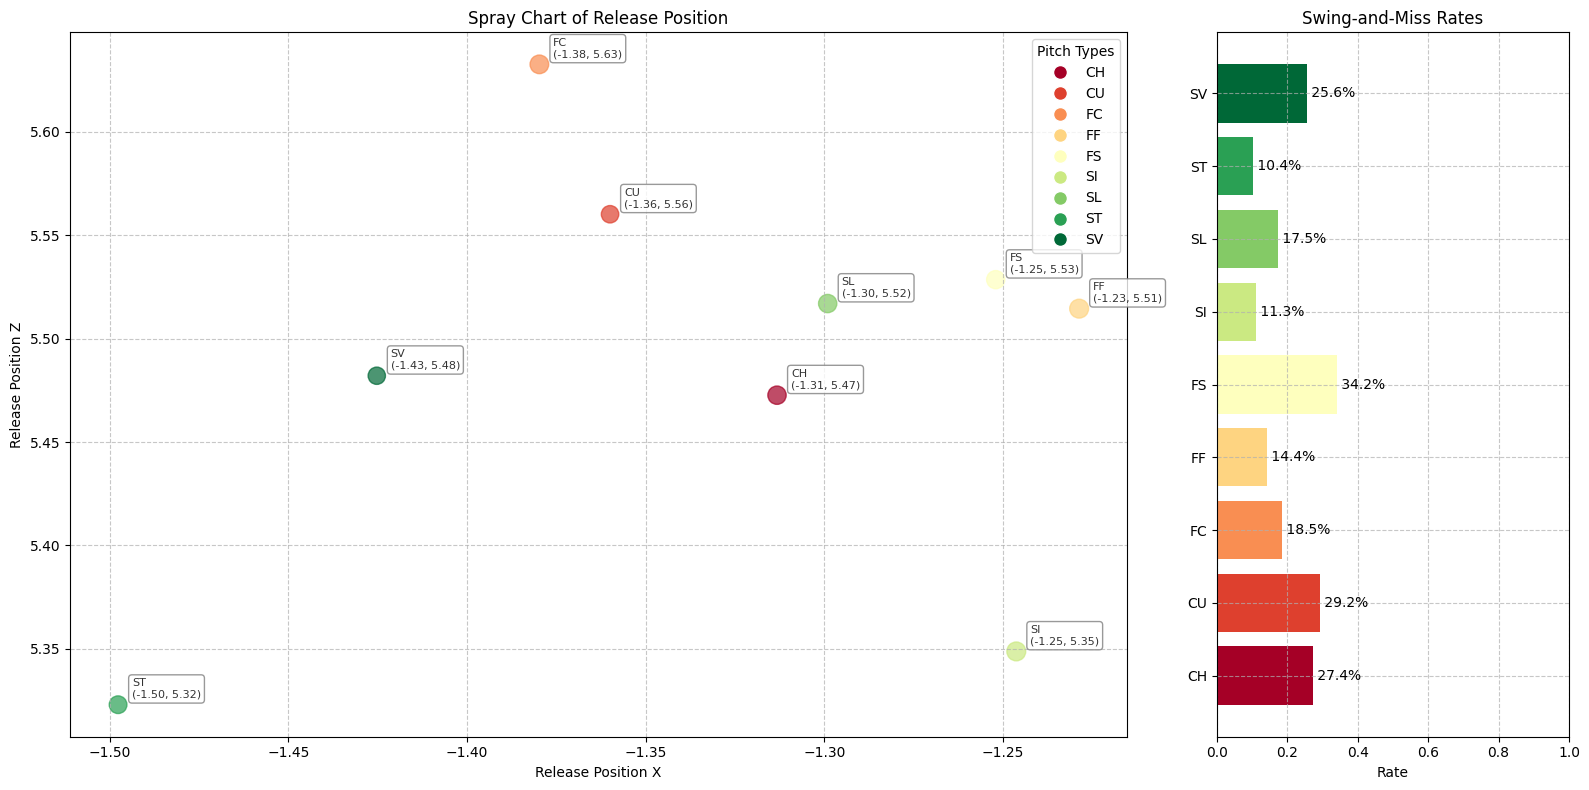

NaN values before outlier removal:
release_pos_x    0
release_pos_y    0
release_pos_z    0
dtype: int64


C:\Users\ramon\AppData\Local\Temp\ipykernel_16096\1289931195.py:132: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  consistency_metrics = clean_data.groupby('pitch_type').apply(calculate_distance_metrics)
C:\Users\ramon\AppData\Local\Temp\ipykernel_16096\1289931195.py:138: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  bar_plot = sns.barplot(x=consistency_metrics.index,
C:\Users\ramon\AppData\Local\Temp\ipykernel_16096\1289931195.py:138: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bar_plot = sns.barplot(x=consis

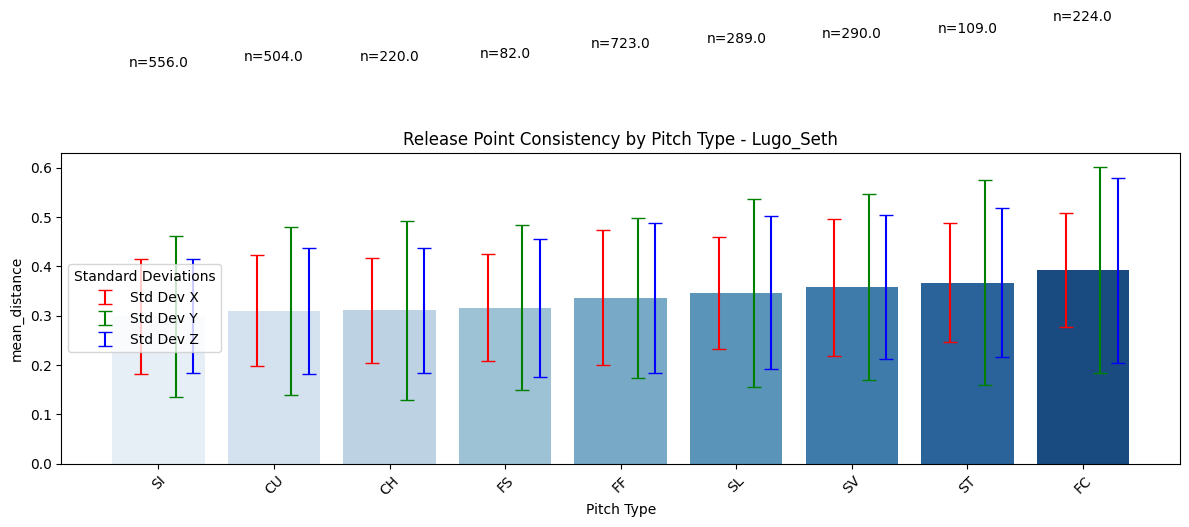

Processing Sale_Chris...
Columns in DataFrame: ['pitch_type', 'game_date', 'release_speed', 'release_pos_x', 'release_pos_z', 'player_name', 'batter', 'pitcher', 'events', 'description', 'spin_dir', 'spin_rate_deprecated', 'break_angle_deprecated', 'break_length_deprecated', 'zone', 'des', 'game_type', 'stand', 'p_throws', 'home_team', 'away_team', 'type', 'hit_location', 'bb_type', 'balls', 'strikes', 'game_year', 'pfx_x', 'pfx_z', 'plate_x', 'plate_z', 'on_3b', 'on_2b', 'on_1b', 'outs_when_up', 'inning', 'inning_topbot', 'hc_x', 'hc_y', 'tfs_deprecated', 'tfs_zulu_deprecated', 'fielder_2', 'umpire', 'sv_id', 'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'sz_top', 'sz_bot', 'hit_distance_sc', 'launch_speed', 'launch_angle', 'effective_speed', 'release_spin_rate', 'release_extension', 'game_pk', 'pitcher.1', 'fielder_2.1', 'fielder_3', 'fielder_4', 'fielder_5', 'fielder_6', 'fielder_7', 'fielder_8', 'fielder_9', 'release_pos_y', 'estimated_ba_using_speedangle', 'estimated_woba_using_speedangl

C:\Users\ramon\AppData\Local\Temp\ipykernel_16096\1289931195.py:132: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  consistency_metrics = clean_data.groupby('pitch_type').apply(calculate_distance_metrics)
C:\Users\ramon\AppData\Local\Temp\ipykernel_16096\1289931195.py:138: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  bar_plot = sns.barplot(x=consistency_metrics.index,
C:\Users\ramon\AppData\Local\Temp\ipykernel_16096\1289931195.py:138: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bar_plot = sns.barplot(x=consis

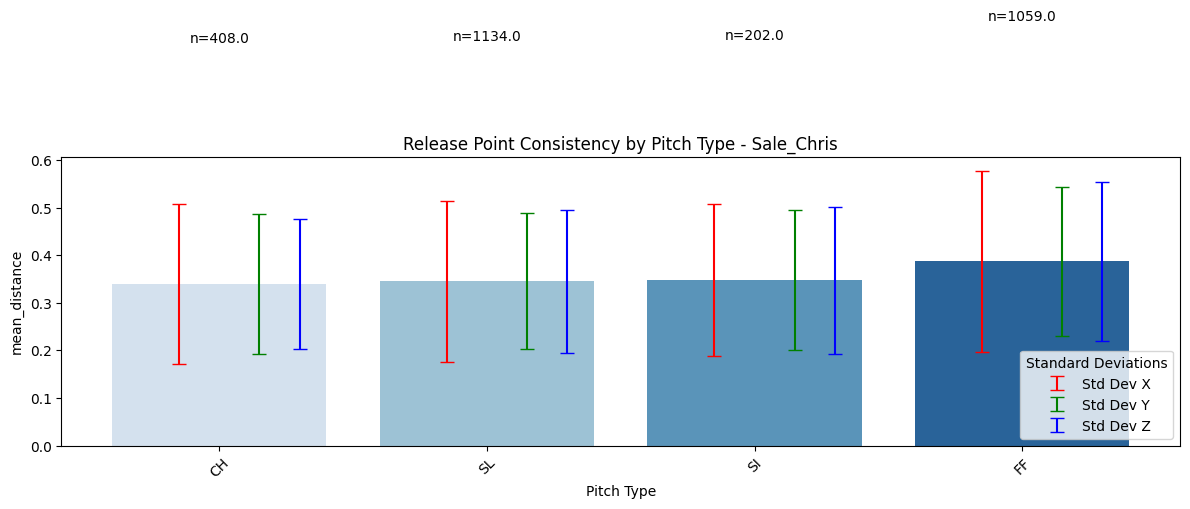

Processing Skenes_Paul...
Columns in DataFrame: ['pitch_type', 'game_date', 'release_speed', 'release_pos_x', 'release_pos_z', 'player_name', 'batter', 'pitcher', 'events', 'description', 'spin_dir', 'spin_rate_deprecated', 'break_angle_deprecated', 'break_length_deprecated', 'zone', 'des', 'game_type', 'stand', 'p_throws', 'home_team', 'away_team', 'type', 'hit_location', 'bb_type', 'balls', 'strikes', 'game_year', 'pfx_x', 'pfx_z', 'plate_x', 'plate_z', 'on_3b', 'on_2b', 'on_1b', 'outs_when_up', 'inning', 'inning_topbot', 'hc_x', 'hc_y', 'tfs_deprecated', 'tfs_zulu_deprecated', 'fielder_2', 'umpire', 'sv_id', 'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'sz_top', 'sz_bot', 'hit_distance_sc', 'launch_speed', 'launch_angle', 'effective_speed', 'release_spin_rate', 'release_extension', 'game_pk', 'pitcher.1', 'fielder_2.1', 'fielder_3', 'fielder_4', 'fielder_5', 'fielder_6', 'fielder_7', 'fielder_8', 'fielder_9', 'release_pos_y', 'estimated_ba_using_speedangle', 'estimated_woba_using_speedang

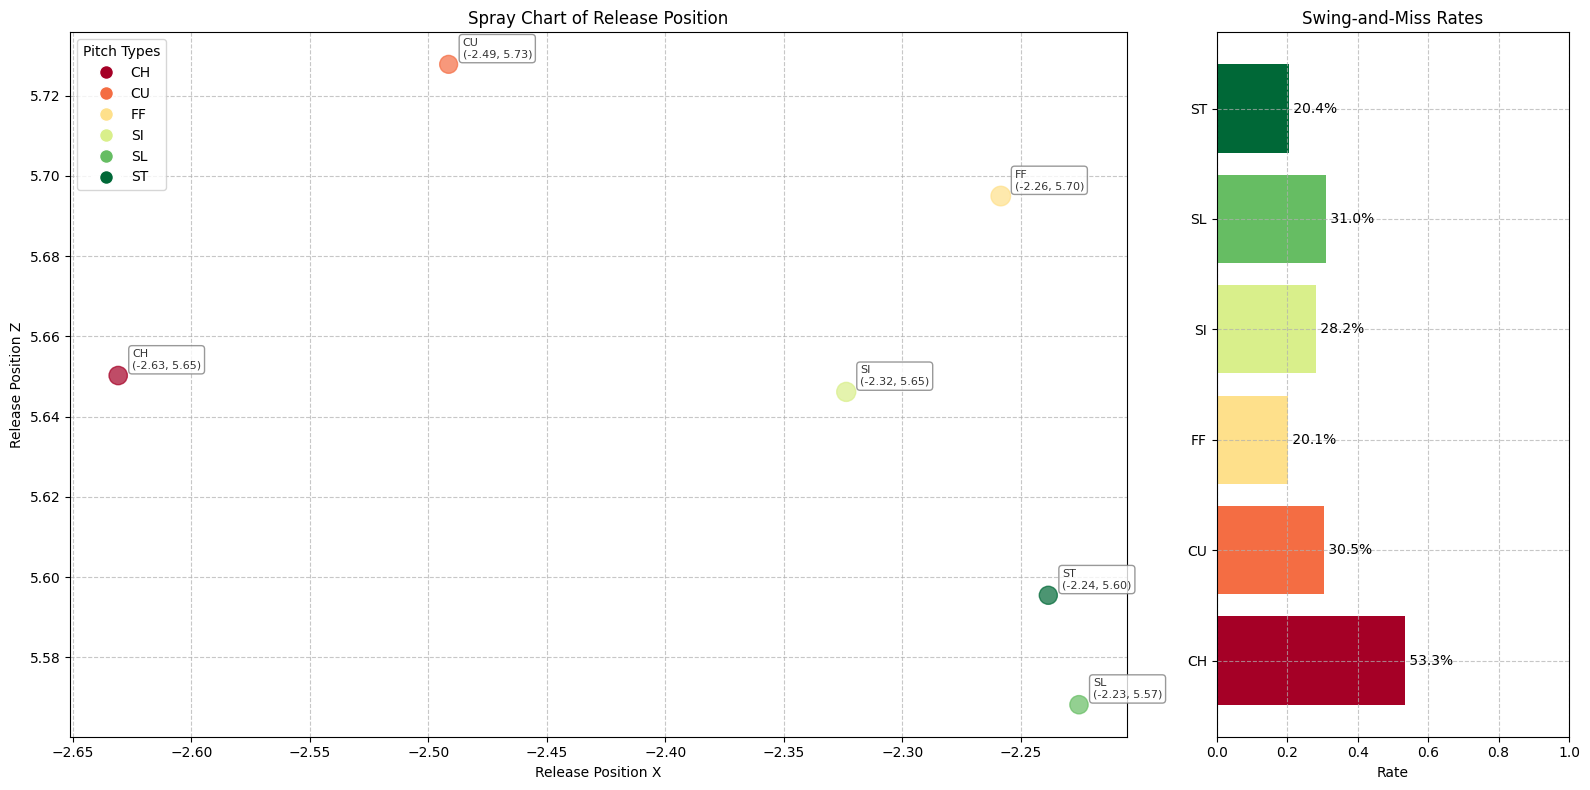

NaN values before outlier removal:
release_pos_x    0
release_pos_y    0
release_pos_z    0
dtype: int64


C:\Users\ramon\AppData\Local\Temp\ipykernel_16096\1289931195.py:132: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  consistency_metrics = clean_data.groupby('pitch_type').apply(calculate_distance_metrics)
C:\Users\ramon\AppData\Local\Temp\ipykernel_16096\1289931195.py:138: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  bar_plot = sns.barplot(x=consistency_metrics.index,
C:\Users\ramon\AppData\Local\Temp\ipykernel_16096\1289931195.py:138: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bar_plot = sns.barplot(x=consis

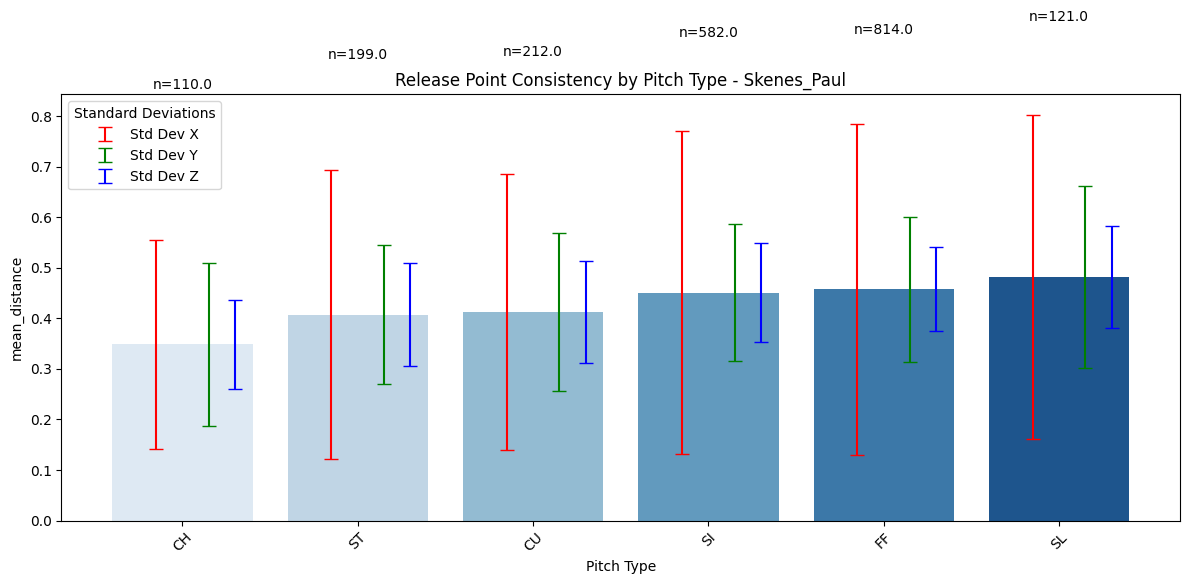

Processing Skubal_Tarik...
Columns in DataFrame: ['pitch_type', 'game_date', 'release_speed', 'release_pos_x', 'release_pos_z', 'player_name', 'batter', 'pitcher', 'events', 'description', 'spin_dir', 'spin_rate_deprecated', 'break_angle_deprecated', 'break_length_deprecated', 'zone', 'des', 'game_type', 'stand', 'p_throws', 'home_team', 'away_team', 'type', 'hit_location', 'bb_type', 'balls', 'strikes', 'game_year', 'pfx_x', 'pfx_z', 'plate_x', 'plate_z', 'on_3b', 'on_2b', 'on_1b', 'outs_when_up', 'inning', 'inning_topbot', 'hc_x', 'hc_y', 'tfs_deprecated', 'tfs_zulu_deprecated', 'fielder_2', 'umpire', 'sv_id', 'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'sz_top', 'sz_bot', 'hit_distance_sc', 'launch_speed', 'launch_angle', 'effective_speed', 'release_spin_rate', 'release_extension', 'game_pk', 'pitcher.1', 'fielder_2.1', 'fielder_3', 'fielder_4', 'fielder_5', 'fielder_6', 'fielder_7', 'fielder_8', 'fielder_9', 'release_pos_y', 'estimated_ba_using_speedangle', 'estimated_woba_using_speedan

C:\Users\ramon\AppData\Local\Temp\ipykernel_16096\1289931195.py:132: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  consistency_metrics = clean_data.groupby('pitch_type').apply(calculate_distance_metrics)
C:\Users\ramon\AppData\Local\Temp\ipykernel_16096\1289931195.py:138: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  bar_plot = sns.barplot(x=consistency_metrics.index,
C:\Users\ramon\AppData\Local\Temp\ipykernel_16096\1289931195.py:138: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bar_plot = sns.barplot(x=consis

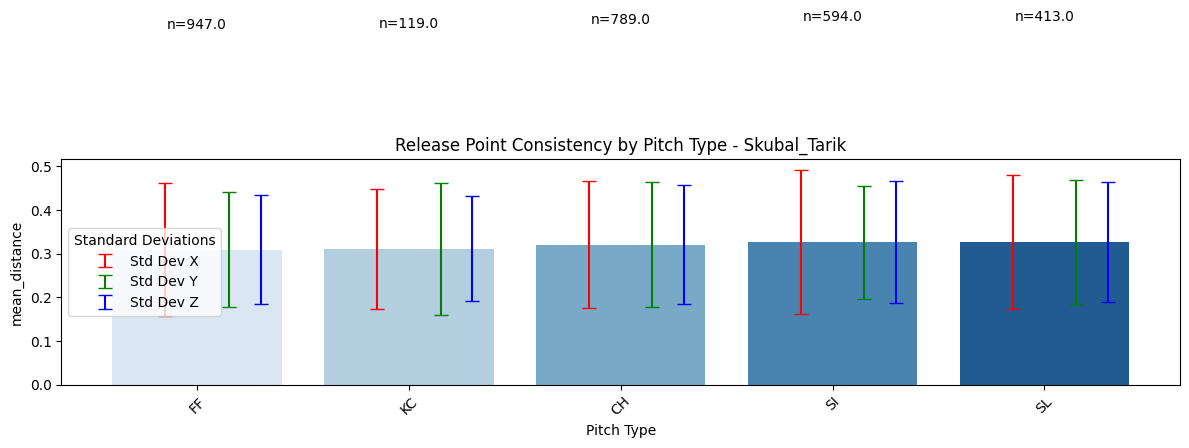

Processing Wheeler_Zack...
Columns in DataFrame: ['pitch_type', 'game_date', 'release_speed', 'release_pos_x', 'release_pos_z', 'player_name', 'batter', 'pitcher', 'events', 'description', 'spin_dir', 'spin_rate_deprecated', 'break_angle_deprecated', 'break_length_deprecated', 'zone', 'des', 'game_type', 'stand', 'p_throws', 'home_team', 'away_team', 'type', 'hit_location', 'bb_type', 'balls', 'strikes', 'game_year', 'pfx_x', 'pfx_z', 'plate_x', 'plate_z', 'on_3b', 'on_2b', 'on_1b', 'outs_when_up', 'inning', 'inning_topbot', 'hc_x', 'hc_y', 'tfs_deprecated', 'tfs_zulu_deprecated', 'fielder_2', 'umpire', 'sv_id', 'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'sz_top', 'sz_bot', 'hit_distance_sc', 'launch_speed', 'launch_angle', 'effective_speed', 'release_spin_rate', 'release_extension', 'game_pk', 'pitcher.1', 'fielder_2.1', 'fielder_3', 'fielder_4', 'fielder_5', 'fielder_6', 'fielder_7', 'fielder_8', 'fielder_9', 'release_pos_y', 'estimated_ba_using_speedangle', 'estimated_woba_using_speedan

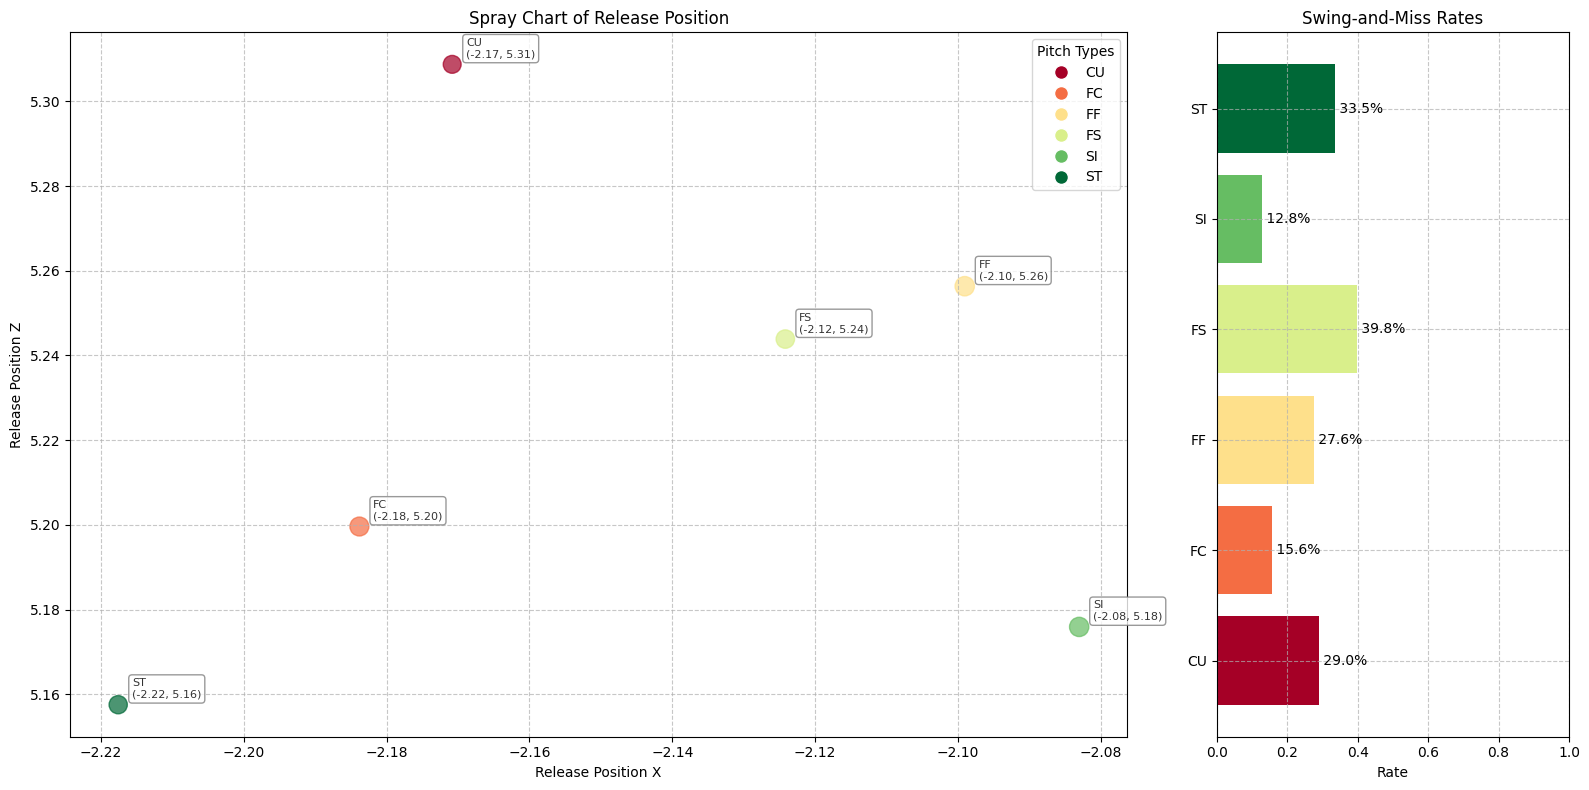

NaN values before outlier removal:
release_pos_x    0
release_pos_y    0
release_pos_z    0
dtype: int64


C:\Users\ramon\AppData\Local\Temp\ipykernel_16096\1289931195.py:132: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  consistency_metrics = clean_data.groupby('pitch_type').apply(calculate_distance_metrics)
C:\Users\ramon\AppData\Local\Temp\ipykernel_16096\1289931195.py:138: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  bar_plot = sns.barplot(x=consistency_metrics.index,
C:\Users\ramon\AppData\Local\Temp\ipykernel_16096\1289931195.py:138: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bar_plot = sns.barplot(x=consis

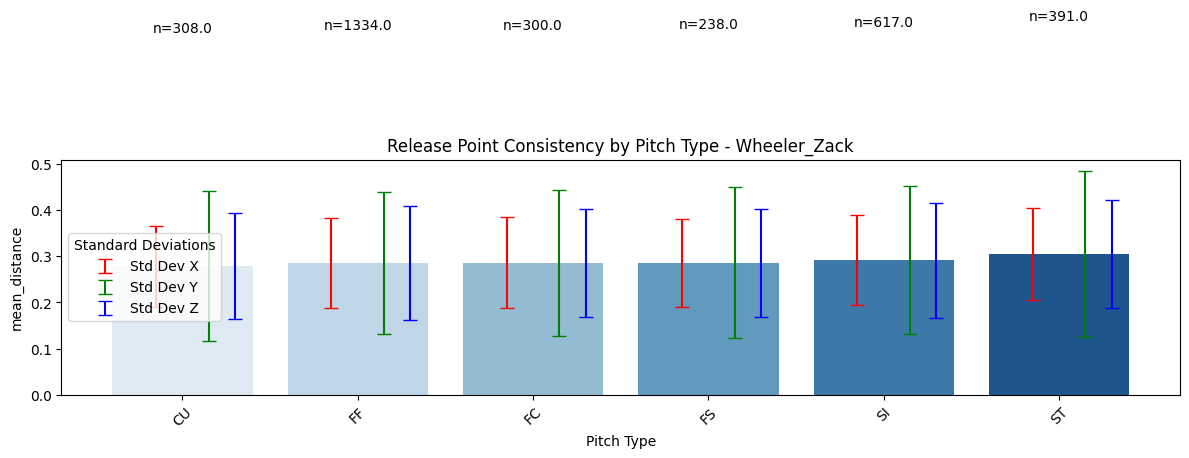

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import pdist
import os

def analyze_pitching_deception(data):
    # Initial data checks
    print("Columns in DataFrame:", data.columns.tolist())
    print("NaN values in release_pos_x:", data['release_pos_x'].isnull().sum())
    print("NaN values in release_pos_z:", data['release_pos_z'].isnull().sum())
    print("NaN values in pitch_type:", data['pitch_type'].isnull().sum())

    # Dropping columns with NaN values (if any)
    data = data.dropna(axis=1)
    
    # Group by pitch type and aggregate
    try:
        pitch_summary = data.groupby('pitch_type').agg({
            'release_pos_x': 'mean',
            'release_pos_y': 'mean',  # Include release_pos_y for correlation
            'release_pos_z': 'mean',
            'effective_speed': 'mean',
            'release_speed': 'mean'
        }).reset_index()

        print("Pitch Summary:")
        print(pitch_summary)
        
    except KeyError as e:
        print(f"KeyError: {e}. Check if all required columns are present.")
        return

    # Calculate total swings and misses for each pitch type
    total_swings = data[data['description'].isin(['swinging_strike', 'foul', 'foul_tip', 'foul_bunt', 
                                                   'bunt_foul_tip', 'missed_bunt', 'hit_into_play'])].groupby('pitch_type').size()
    total_misses = data[data['description'] == 'swinging_strike'].groupby('pitch_type').size()

    swing_and_miss_rate = (total_misses / total_swings).fillna(0).reset_index(name='swing_and_miss_rate')

    # Merge swing-and-miss rates back to original data
    pitch_summary = pitch_summary.merge(swing_and_miss_rate, on='pitch_type', how='left')

    # Perform correlation analysis (Pearson correlation) including release_pos_y
    correlation = pitch_summary[['swing_and_miss_rate', 'release_pos_x', 'release_pos_y', 'release_pos_z']].corr()
    
    print("Correlation Matrix:")
    print(correlation)

    # Visualization
    colors = plt.cm.RdYlGn(np.linspace(0, 1, len(pitch_summary)))

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8), gridspec_kw={'width_ratios': [3, 1]})
    
    scatter = ax1.scatter(pitch_summary['release_pos_x'], pitch_summary['release_pos_z'],
                          s=pitch_summary['effective_speed'] * 2,
                          c=colors,
                          alpha=0.7)

    for idx, row in pitch_summary.iterrows():
        ax1.annotate(f"{row['pitch_type']}\n({row['release_pos_x']:.2f}, {row['release_pos_z']:.2f})",
                     (row['release_pos_x'], row['release_pos_z']),
                     xytext=(10, 5),
                     textcoords='offset points',
                     fontsize=8,
                     alpha=0.8,
                     bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))

    ax1.set_title(f'Spray Chart of Release Position')
    ax1.set_xlabel('Release Position X')
    ax1.set_ylabel('Release Position Z')

    legend_elements = [plt.Line2D([0], [0], marker='o', color='w',
                                  label=pitch, markerfacecolor=color, markersize=10)
                       for pitch, color in zip(pitch_summary['pitch_type'], colors)]
    
    ax1.legend(handles=legend_elements, title='Pitch Types', loc='best')
    ax1.grid(True, linestyle='--', alpha=0.7)

    ax2.barh(pitch_summary['pitch_type'], pitch_summary['swing_and_miss_rate'], color=colors)
    ax2.set_title(f'Swing-and-Miss Rates')
    ax2.set_xlabel('Rate')
    ax2.set_xlim(0, 1)

    for i, v in enumerate(pitch_summary['swing_and_miss_rate']):
        ax2.text(v, i, f' {v:.1%}', va='center')

    ax2.grid(True, linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    
    return plt.show()

def analyze_release_point_consistency(data, pitcher_name):
    clean_data = data.dropna(subset=['pitch_type', 'release_pos_x', 'release_pos_y', 'release_pos_z'])

    # Check for NaN values before filtering outliers
    print("NaN values before outlier removal:")
    print(clean_data[['release_pos_x', 'release_pos_y', 'release_pos_z']].isnull().sum())

    # Filter outliers using IQR method for release position coordinates
    for col in ['release_pos_x', 'release_pos_y', 'release_pos_z']:
        Q1 = clean_data[col].quantile(0.25)
        Q3 = clean_data[col].quantile(0.75)
        IQR = Q3 - Q1
        
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        clean_data = clean_data[(clean_data[col] >= lower_bound) & (clean_data[col] <= upper_bound)]

    def calculate_distance_metrics(group):
        release_points = group[['release_pos_x', 'release_pos_y', 'release_pos_z']].values
        if len(release_points) < 2:
            return pd.Series({
                'mean_distance': np.nan,
                'std_distance_x': np.nan,
                'std_distance_y': np.nan,
                'std_distance_z': np.nan,
                'count': len(group)
            })
        distances = pdist(release_points)
        return pd.Series({
            'mean_distance': np.mean(distances),
            'std_distance_x': np.std(group['release_pos_x']),
            'std_distance_y': np.std(group['release_pos_y']),
            'std_distance_z': np.std(group['release_pos_z']),
            'count': len(group)
        })

    consistency_metrics = clean_data.groupby('pitch_type').apply(calculate_distance_metrics)
    
    consistency_metrics = consistency_metrics.sort_values('mean_distance', na_position='last')
    
    plt.figure(figsize=(12, 6))
    
    bar_plot = sns.barplot(x=consistency_metrics.index,
                           y='mean_distance',
                           data=consistency_metrics,
                           palette='Blues',
                           ci=None)

    # Adjust error bars to avoid overlap and add labels to the legend
    x_positions = np.arange(len(consistency_metrics.index))
    
    # Define offsets for the error bars
    offset_width = 0.15  # Adjust this value to increase/decrease spacing

    plt.errorbar(x=x_positions - offset_width,  # X position for std_dev_x
                 y=consistency_metrics['mean_distance'],
                 yerr=consistency_metrics['std_distance_x'],
                 fmt='none',
                 c='red',
                 capsize=5,
                 label='Std Dev X')

    plt.errorbar(x=x_positions + offset_width,  # X position for std_dev_y
                 y=consistency_metrics['mean_distance'],
                 yerr=consistency_metrics['std_distance_y'],
                 fmt='none',
                 c='green',
                 capsize=5,
                 label='Std Dev Y')

    plt.errorbar(x=x_positions + offset_width * 2,  # X position for std_dev_z
                 y=consistency_metrics['mean_distance'],
                 yerr=consistency_metrics['std_distance_z'],
                 fmt='none',
                 c='blue',
                 capsize=5,
                 label='Std Dev Z')

    for i, row in enumerate(consistency_metrics.itertuples()):
        plt.text(i, row.mean_distance + 0.5, f'n={row.count}', ha='center', va='bottom')

    plt.legend(title='Standard Deviations')
    
    plt.title(f'Release Point Consistency by Pitch Type - {pitcher_name}')
    plt.xlabel('Pitch Type')
    
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    
    plots_folder = 'Release_Point_Consistency_Plots'
    os.makedirs(plots_folder, exist_ok=True)
    
    plt.savefig(os.path.join(plots_folder, f'{pitcher_name}_Release_Point_Consistency.png'))
    
    plt.show()

def main():
    csv_folder = 'CSV_Files'
    
    csv_files = [f for f in os.listdir(csv_folder) if f.endswith('.csv')]

    for csv_file in csv_files:
        pitcher_name = '_'.join(csv_file.split('_')[:2])  # Assumes format "LastName_FirstName_Year.csv"
        
        file_path = os.path.join(csv_folder, csv_file)

        try:
            data = pd.read_csv(file_path)
            print(f"Processing {pitcher_name}...")
            
            analyze_pitching_deception(data)
            analyze_release_point_consistency(data, pitcher_name=pitcher_name)
            
        except Exception as e:
            print(f"Error processing {pitcher_name}: {e}")

if __name__ == "__main__":
    main()

MACHINE LEARNING APPROACH

Processing Lugo_Seth...
Columns in DataFrame: ['pitch_type', 'game_date', 'release_speed', 'release_pos_x', 'release_pos_z', 'player_name', 'batter', 'pitcher', 'events', 'description', 'spin_dir', 'spin_rate_deprecated', 'break_angle_deprecated', 'break_length_deprecated', 'zone', 'des', 'game_type', 'stand', 'p_throws', 'home_team', 'away_team', 'type', 'hit_location', 'bb_type', 'balls', 'strikes', 'game_year', 'pfx_x', 'pfx_z', 'plate_x', 'plate_z', 'on_3b', 'on_2b', 'on_1b', 'outs_when_up', 'inning', 'inning_topbot', 'hc_x', 'hc_y', 'tfs_deprecated', 'tfs_zulu_deprecated', 'fielder_2', 'umpire', 'sv_id', 'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'sz_top', 'sz_bot', 'hit_distance_sc', 'launch_speed', 'launch_angle', 'effective_speed', 'release_spin_rate', 'release_extension', 'game_pk', 'pitcher.1', 'fielder_2.1', 'fielder_3', 'fielder_4', 'fielder_5', 'fielder_6', 'fielder_7', 'fielder_8', 'fielder_9', 'release_pos_y', 'estimated_ba_using_speedangle', 'estimated_woba_using_speedangle

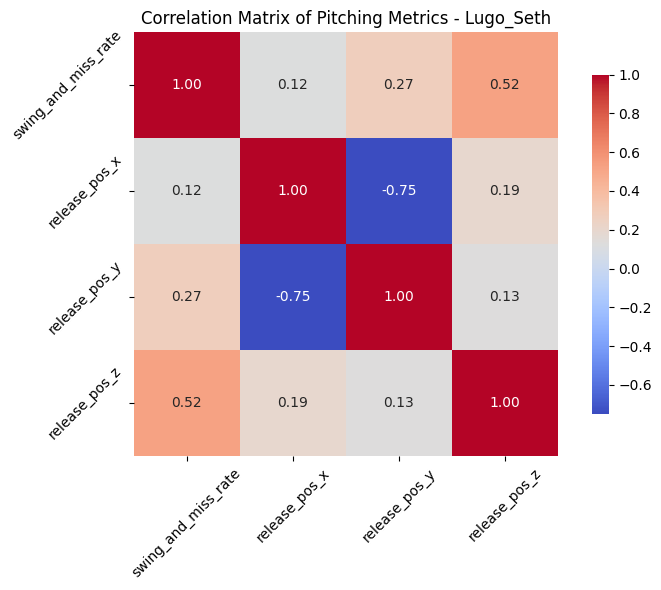

NaN values before outlier removal:
release_pos_x    0
release_pos_y    0
release_pos_z    0
dtype: int64


C:\Users\ramon\AppData\Local\Temp\ipykernel_16096\1750548098.py:112: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  consistency_metrics = clean_data.groupby('pitch_type').apply(calculate_distance_metrics)
C:\Users\ramon\AppData\Local\Temp\ipykernel_16096\1750548098.py:118: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  bar_plot = sns.barplot(x=consistency_metrics.index,
C:\Users\ramon\AppData\Local\Temp\ipykernel_16096\1750548098.py:118: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bar_plot = sns.barplot(x=consis

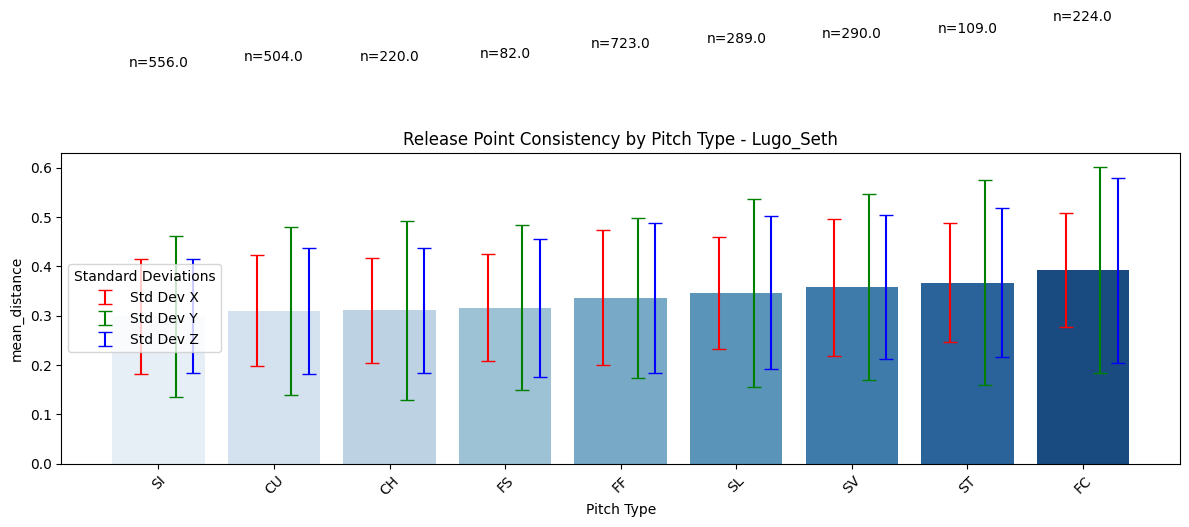

Processing Sale_Chris...
Columns in DataFrame: ['pitch_type', 'game_date', 'release_speed', 'release_pos_x', 'release_pos_z', 'player_name', 'batter', 'pitcher', 'events', 'description', 'spin_dir', 'spin_rate_deprecated', 'break_angle_deprecated', 'break_length_deprecated', 'zone', 'des', 'game_type', 'stand', 'p_throws', 'home_team', 'away_team', 'type', 'hit_location', 'bb_type', 'balls', 'strikes', 'game_year', 'pfx_x', 'pfx_z', 'plate_x', 'plate_z', 'on_3b', 'on_2b', 'on_1b', 'outs_when_up', 'inning', 'inning_topbot', 'hc_x', 'hc_y', 'tfs_deprecated', 'tfs_zulu_deprecated', 'fielder_2', 'umpire', 'sv_id', 'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'sz_top', 'sz_bot', 'hit_distance_sc', 'launch_speed', 'launch_angle', 'effective_speed', 'release_spin_rate', 'release_extension', 'game_pk', 'pitcher.1', 'fielder_2.1', 'fielder_3', 'fielder_4', 'fielder_5', 'fielder_6', 'fielder_7', 'fielder_8', 'fielder_9', 'release_pos_y', 'estimated_ba_using_speedangle', 'estimated_woba_using_speedangl

C:\Users\ramon\AppData\Local\Temp\ipykernel_16096\1750548098.py:112: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  consistency_metrics = clean_data.groupby('pitch_type').apply(calculate_distance_metrics)
C:\Users\ramon\AppData\Local\Temp\ipykernel_16096\1750548098.py:118: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  bar_plot = sns.barplot(x=consistency_metrics.index,
C:\Users\ramon\AppData\Local\Temp\ipykernel_16096\1750548098.py:118: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bar_plot = sns.barplot(x=consis

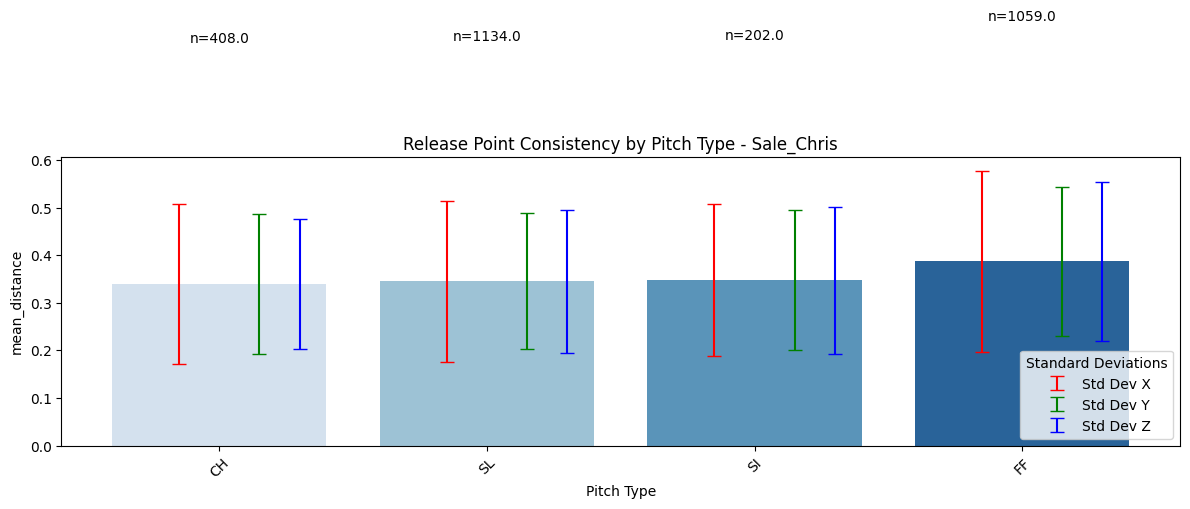

Processing Skenes_Paul...
Columns in DataFrame: ['pitch_type', 'game_date', 'release_speed', 'release_pos_x', 'release_pos_z', 'player_name', 'batter', 'pitcher', 'events', 'description', 'spin_dir', 'spin_rate_deprecated', 'break_angle_deprecated', 'break_length_deprecated', 'zone', 'des', 'game_type', 'stand', 'p_throws', 'home_team', 'away_team', 'type', 'hit_location', 'bb_type', 'balls', 'strikes', 'game_year', 'pfx_x', 'pfx_z', 'plate_x', 'plate_z', 'on_3b', 'on_2b', 'on_1b', 'outs_when_up', 'inning', 'inning_topbot', 'hc_x', 'hc_y', 'tfs_deprecated', 'tfs_zulu_deprecated', 'fielder_2', 'umpire', 'sv_id', 'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'sz_top', 'sz_bot', 'hit_distance_sc', 'launch_speed', 'launch_angle', 'effective_speed', 'release_spin_rate', 'release_extension', 'game_pk', 'pitcher.1', 'fielder_2.1', 'fielder_3', 'fielder_4', 'fielder_5', 'fielder_6', 'fielder_7', 'fielder_8', 'fielder_9', 'release_pos_y', 'estimated_ba_using_speedangle', 'estimated_woba_using_speedang

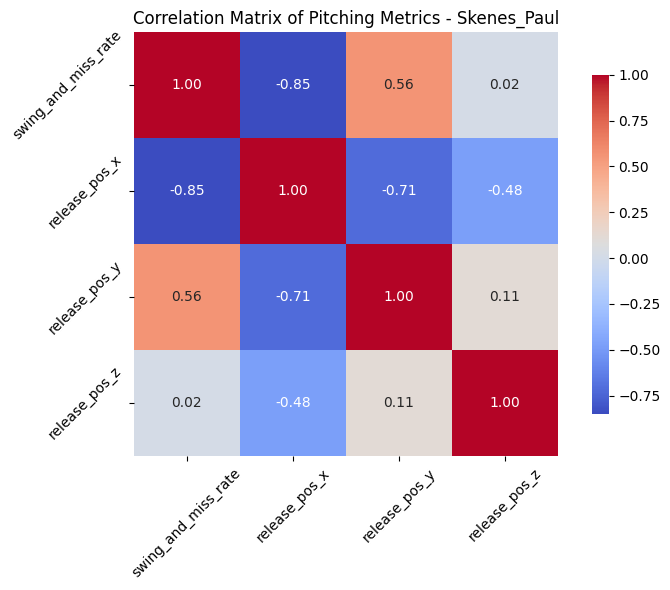

NaN values before outlier removal:
release_pos_x    0
release_pos_y    0
release_pos_z    0
dtype: int64


C:\Users\ramon\AppData\Local\Temp\ipykernel_16096\1750548098.py:112: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  consistency_metrics = clean_data.groupby('pitch_type').apply(calculate_distance_metrics)
C:\Users\ramon\AppData\Local\Temp\ipykernel_16096\1750548098.py:118: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  bar_plot = sns.barplot(x=consistency_metrics.index,
C:\Users\ramon\AppData\Local\Temp\ipykernel_16096\1750548098.py:118: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bar_plot = sns.barplot(x=consis

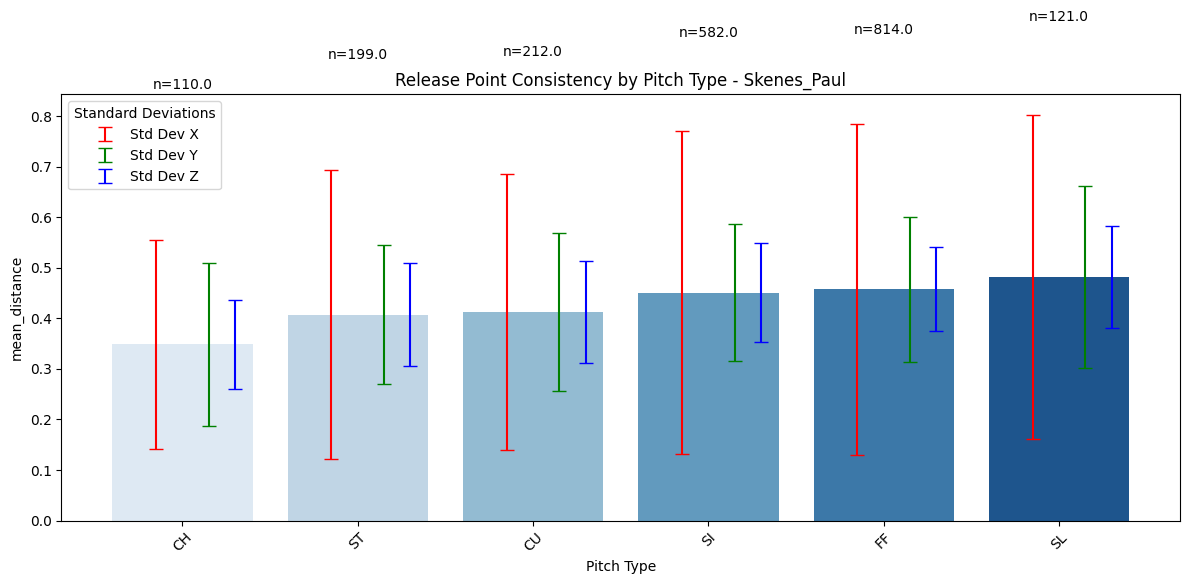

Processing Skubal_Tarik...
Columns in DataFrame: ['pitch_type', 'game_date', 'release_speed', 'release_pos_x', 'release_pos_z', 'player_name', 'batter', 'pitcher', 'events', 'description', 'spin_dir', 'spin_rate_deprecated', 'break_angle_deprecated', 'break_length_deprecated', 'zone', 'des', 'game_type', 'stand', 'p_throws', 'home_team', 'away_team', 'type', 'hit_location', 'bb_type', 'balls', 'strikes', 'game_year', 'pfx_x', 'pfx_z', 'plate_x', 'plate_z', 'on_3b', 'on_2b', 'on_1b', 'outs_when_up', 'inning', 'inning_topbot', 'hc_x', 'hc_y', 'tfs_deprecated', 'tfs_zulu_deprecated', 'fielder_2', 'umpire', 'sv_id', 'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'sz_top', 'sz_bot', 'hit_distance_sc', 'launch_speed', 'launch_angle', 'effective_speed', 'release_spin_rate', 'release_extension', 'game_pk', 'pitcher.1', 'fielder_2.1', 'fielder_3', 'fielder_4', 'fielder_5', 'fielder_6', 'fielder_7', 'fielder_8', 'fielder_9', 'release_pos_y', 'estimated_ba_using_speedangle', 'estimated_woba_using_speedan

C:\Users\ramon\AppData\Local\Temp\ipykernel_16096\1750548098.py:112: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  consistency_metrics = clean_data.groupby('pitch_type').apply(calculate_distance_metrics)
C:\Users\ramon\AppData\Local\Temp\ipykernel_16096\1750548098.py:118: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  bar_plot = sns.barplot(x=consistency_metrics.index,
C:\Users\ramon\AppData\Local\Temp\ipykernel_16096\1750548098.py:118: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bar_plot = sns.barplot(x=consis

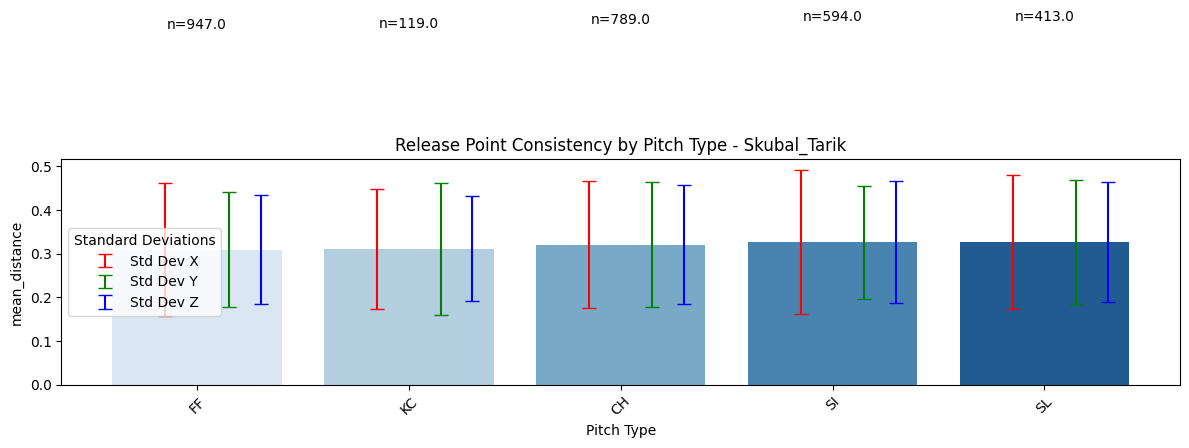

Processing Wheeler_Zack...
Columns in DataFrame: ['pitch_type', 'game_date', 'release_speed', 'release_pos_x', 'release_pos_z', 'player_name', 'batter', 'pitcher', 'events', 'description', 'spin_dir', 'spin_rate_deprecated', 'break_angle_deprecated', 'break_length_deprecated', 'zone', 'des', 'game_type', 'stand', 'p_throws', 'home_team', 'away_team', 'type', 'hit_location', 'bb_type', 'balls', 'strikes', 'game_year', 'pfx_x', 'pfx_z', 'plate_x', 'plate_z', 'on_3b', 'on_2b', 'on_1b', 'outs_when_up', 'inning', 'inning_topbot', 'hc_x', 'hc_y', 'tfs_deprecated', 'tfs_zulu_deprecated', 'fielder_2', 'umpire', 'sv_id', 'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'sz_top', 'sz_bot', 'hit_distance_sc', 'launch_speed', 'launch_angle', 'effective_speed', 'release_spin_rate', 'release_extension', 'game_pk', 'pitcher.1', 'fielder_2.1', 'fielder_3', 'fielder_4', 'fielder_5', 'fielder_6', 'fielder_7', 'fielder_8', 'fielder_9', 'release_pos_y', 'estimated_ba_using_speedangle', 'estimated_woba_using_speedan

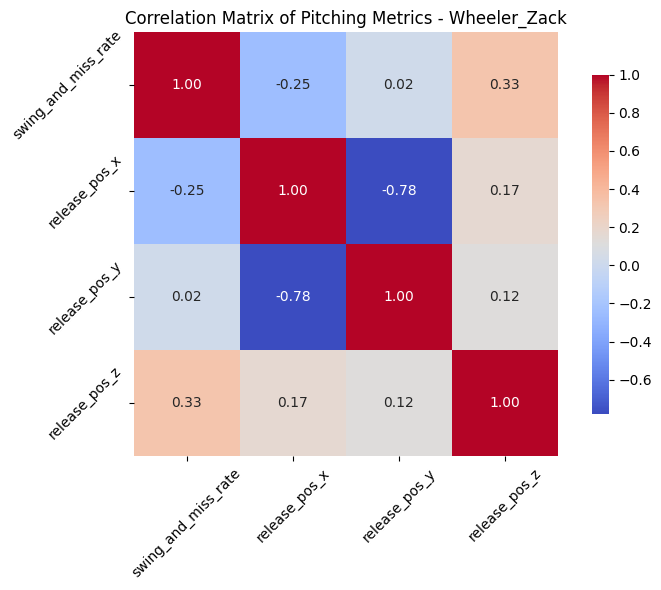

NaN values before outlier removal:
release_pos_x    0
release_pos_y    0
release_pos_z    0
dtype: int64


C:\Users\ramon\AppData\Local\Temp\ipykernel_16096\1750548098.py:112: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  consistency_metrics = clean_data.groupby('pitch_type').apply(calculate_distance_metrics)
C:\Users\ramon\AppData\Local\Temp\ipykernel_16096\1750548098.py:118: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  bar_plot = sns.barplot(x=consistency_metrics.index,
C:\Users\ramon\AppData\Local\Temp\ipykernel_16096\1750548098.py:118: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bar_plot = sns.barplot(x=consis

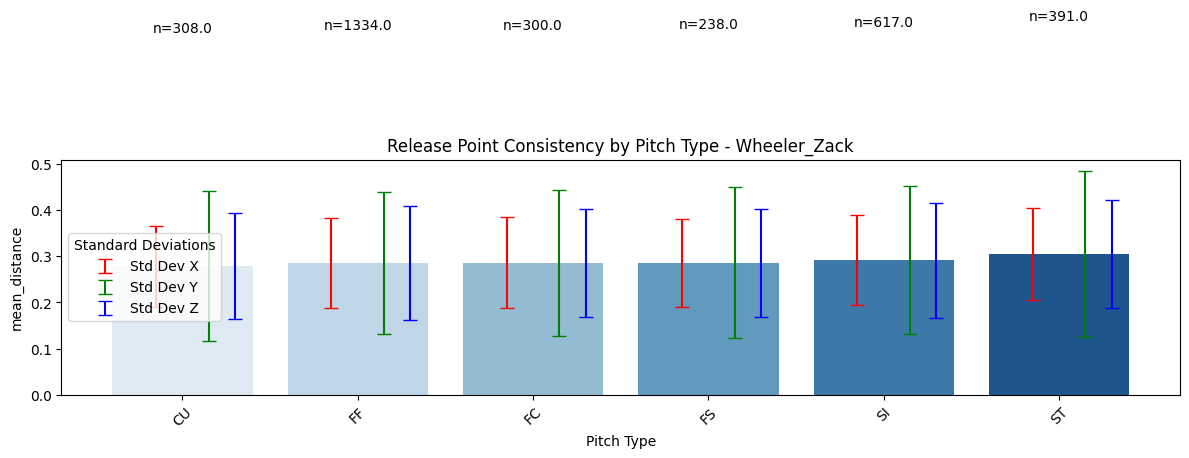

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import pdist
import os

def analyze_pitching_deception(data, pitcher_name):
    # Initial data checks
    print("Columns in DataFrame:", data.columns.tolist())
    print("NaN values in release_pos_x:", data['release_pos_x'].isnull().sum())
    print("NaN values in release_pos_z:", data['release_pos_z'].isnull().sum())
    print("NaN values in pitch_type:", data['pitch_type'].isnull().sum())

    # Check for NaN values before proceeding
    if data['release_pos_x'].isnull().any() or data['release_pos_z'].isnull().any() or data['pitch_type'].isnull().any():
        print(f"Skipping {pitcher_name} due to NaN values in required columns.")
        return

    # Dropping columns with NaN values (if any)
    data = data.dropna(axis=1)
    
    # Group by pitch type and aggregate
    try:
        pitch_summary = data.groupby('pitch_type').agg({
            'release_pos_x': 'mean',
            'release_pos_y': 'mean',  # Include release_pos_y for correlation
            'release_pos_z': 'mean',
            'effective_speed': 'mean',
            'release_speed': 'mean'
        }).reset_index()

        print("Pitch Summary:")
        print(pitch_summary)
        
    except KeyError as e:
        print(f"KeyError: {e}. Check if all required columns are present.")
        return

    # Calculate total swings and misses for each pitch type
    total_swings = data[data['description'].isin(['swinging_strike', 'foul', 'foul_tip', 'foul_bunt', 
                                                   'bunt_foul_tip', 'missed_bunt', 'hit_into_play'])].groupby('pitch_type').size()
    total_misses = data[data['description'] == 'swinging_strike'].groupby('pitch_type').size()

    swing_and_miss_rate = (total_misses / total_swings).fillna(0).reset_index(name='swing_and_miss_rate')

    # Merge swing-and-miss rates back to original data
    pitch_summary = pitch_summary.merge(swing_and_miss_rate, on='pitch_type', how='left')

    # Perform correlation analysis (Pearson correlation) including release_pos_y
    correlation = pitch_summary[['swing_and_miss_rate', 'release_pos_x', 'release_pos_y', 'release_pos_z']].corr()
    
    print("Correlation Matrix:")
    print(correlation)

    # Plotting the correlation matrix as a heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(correlation, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
    
    plt.title(f'Correlation Matrix of Pitching Metrics - {pitcher_name}')
    plt.xticks(rotation=45)
    plt.yticks(rotation=45)
    
    plt.tight_layout()

    # Create a new folder for saving plots if it doesn't exist
    plots_folder = 'Correlation_Matrix_Plots'
    os.makedirs(plots_folder, exist_ok=True)

    # Save the heatmap
    plt.savefig(os.path.join(plots_folder, f'{pitcher_name}_correlation_matrix.png'))
        
    plt.show()  # Ensure this is called to display the heatmap

def analyze_release_point_consistency(data, pitcher_name):
   clean_data = data.dropna(subset=['pitch_type', 'release_pos_x', 'release_pos_y', 'release_pos_z'])

   # Check for NaN values before filtering outliers
   print("NaN values before outlier removal:")
   print(clean_data[['release_pos_x', 'release_pos_y', 'release_pos_z']].isnull().sum())

   # Filter outliers using IQR method for release position coordinates
   for col in ['release_pos_x', 'release_pos_y', 'release_pos_z']:
       Q1 = clean_data[col].quantile(0.25)
       Q3 = clean_data[col].quantile(0.75)
       IQR = Q3 - Q1
        
       lower_bound = Q1 - 1.5 * IQR
       upper_bound = Q3 + 1.5 * IQR
        
       clean_data = clean_data[(clean_data[col] >= lower_bound) & (clean_data[col] <= upper_bound)]

   def calculate_distance_metrics(group):
       release_points = group[['release_pos_x', 'release_pos_y', 'release_pos_z']].values
       if len(release_points) < 2:
           return pd.Series({
               'mean_distance': np.nan,
               'std_distance_x': np.nan,
               'std_distance_y': np.nan,
               'std_distance_z': np.nan,
               'count': len(group)
           })
       distances = pdist(release_points)
       return pd.Series({
           'mean_distance': np.mean(distances),
           'std_distance_x': np.std(group['release_pos_x']),
           'std_distance_y': np.std(group['release_pos_y']),
           'std_distance_z': np.std(group['release_pos_z']),
           'count': len(group)
       })

   consistency_metrics = clean_data.groupby('pitch_type').apply(calculate_distance_metrics)
    
   consistency_metrics = consistency_metrics.sort_values('mean_distance', na_position='last')
    
   plt.figure(figsize=(12, 6))
    
   bar_plot = sns.barplot(x=consistency_metrics.index,
                          y='mean_distance',
                          data=consistency_metrics,
                          palette='Blues',
                          ci=None)

   # Adjust error bars to avoid overlap and add labels to the legend
   x_positions = np.arange(len(consistency_metrics.index))
    
   # Define offsets for the error bars
   offset_width = 0.15  # Adjust this value to increase/decrease spacing

   plt.errorbar(x=x_positions - offset_width,  # X position for std_dev_x
                y=consistency_metrics['mean_distance'],
                yerr=consistency_metrics['std_distance_x'],
                fmt='none',
                c='red',
                capsize=5,
                label='Std Dev X')

   plt.errorbar(x=x_positions + offset_width,  # X position for std_dev_y
                y=consistency_metrics['mean_distance'],
                yerr=consistency_metrics['std_distance_y'],
                fmt='none',
                c='green',
                capsize=5,
                label='Std Dev Y')

   plt.errorbar(x=x_positions + offset_width * 2,  # X position for std_dev_z
                y=consistency_metrics['mean_distance'],
                yerr=consistency_metrics['std_distance_z'],
                fmt='none',
                c='blue',
                capsize=5,
                label='Std Dev Z')

   for i, row in enumerate(consistency_metrics.itertuples()):
       plt.text(i, row.mean_distance + 0.5, f'n={row.count}', ha='center', va='bottom')

   plt.legend(title='Standard Deviations')
    
   plt.title(f'Release Point Consistency by Pitch Type - {pitcher_name}')
   plt.xlabel('Pitch Type')
    
   plt.xticks(rotation=45)
    
   plt.tight_layout()
    
   plots_folder = 'Release_Point_Consistency_Plots'
   os.makedirs(plots_folder, exist_ok=True)
    
   plt.savefig(os.path.join(plots_folder, f'{pitcher_name}_Release_Point_Consistency.png'))
    
   plt.show()

def main():
   csv_folder = 'CSV_Files'
    
   csv_files = [f for f in os.listdir(csv_folder) if f.endswith('.csv')]

   for csv_file in csv_files:
       pitcher_name = '_'.join(csv_file.split('_')[:2])  # Assumes format "LastName_FirstName_Year.csv"
        
       file_path = os.path.join(csv_folder, csv_file)

       try:
           data = pd.read_csv(file_path)
           print(f"Processing {pitcher_name}...")
            
           analyze_pitching_deception(data, pitcher_name)  # Pass pitcher name to function
           analyze_release_point_consistency(data, pitcher_name=pitcher_name)
            
       except Exception as e:
           print(f"Error processing {pitcher_name}: {e}")

if __name__ == "__main__":
   main()